In [1]:
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import numpy as np
from tqdm import tqdm

### Configuration

In [2]:
DATA_DIR="../data/cluster/UP000005640_9606/"
PROTEOME_NAME="UP000005640_9606"

In [3]:
PLDDT_SCORES_JSON=os.path.join(DATA_DIR,f"{PROTEOME_NAME}_HUMAN_v3_plddts_fltrd.json")
SETH_SCORES_FASTA=os.path.join(DATA_DIR,"Human_SETH_preds.txt")
NEFF_GPU_SCORES_JSON=os.path.join(DATA_DIR,f"{PROTEOME_NAME}_neff_fast.json")
NEFF_MMSEQS_SCORES_JSON=os.path.join(DATA_DIR,f"{PROTEOME_NAME}_neff_mmseqs.json")
NEFF_HHSUITE_SCORES_DIR=os.path.join(DATA_DIR,f"{PROTEOME_NAME}_neff_hhsuite.json")
NEFF_NAIVE_SCORES_DIR=os.path.join(DATA_DIR,f"{PROTEOME_NAME}_neff_naive.json")

In [4]:
colors = sns.color_palette("colorblind")
colors

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

### Load scores

Per-protein per-residue scores for each metric.

In [5]:
total_num_proteins = 20601  # proteins in msa folder

In [6]:
# load pLDDT scores
with open(PLDDT_SCORES_JSON) as f:
    plddt = json.load(f)
    plddt = {p:torch.tensor(xs) for p,xs in plddt.items()}
print(len(plddt), "plddt scores loaded")

20296 plddt scores loaded


In [7]:
# load SETH scores
with open(SETH_SCORES_FASTA) as f:
    seth = {}
    lines = f.readlines()
    for hdr,scores in zip(lines[::2],lines[1::2]):
        hdrid=hdr.split("|")[1]
        score=torch.tensor([float(s) for s in scores.split(", ")])
        seth[hdrid]=score
print(len(seth), "SETH scores loaded")

20352 SETH scores loaded


In [8]:
# load Neff gpu scores
with open(NEFF_GPU_SCORES_JSON) as f:
    neff_gpu = json.load(f)
    neff_gpu = {p:torch.tensor(xs) for p,xs in neff_gpu.items()}
print(len(neff_gpu), "neff gpu scores loaded")

18741 neff gpu scores loaded


In [9]:
# load neff mmseqs2 scores
with open(NEFF_MMSEQS_SCORES_JSON) as f:
    neff_mmseqs = json.load(f)
    neff_mmseqs = {p:torch.tensor(xs) for p,xs in neff_mmseqs.items()}
print(len(neff_mmseqs), "neff mmseqs2 scores loaded")

20600 neff mmseqs2 scores loaded


In [10]:
# load Neff hhsuite scores
with open(NEFF_HHSUITE_SCORES_DIR) as f:
    neff_hhsuite = json.load(f)
    neff_hhsuite = {p:torch.tensor(xs) for p,xs in neff_hhsuite.items()}
print(len(neff_hhsuite), "neff hhsuite scores loaded")

20599 neff hhsuite scores loaded


In [11]:
# load Neff naive scores
with open(NEFF_NAIVE_SCORES_DIR) as f:
    neff_naive = json.load(f)
    neff_naive = {p:torch.tensor(xs) for p,xs in neff_naive.items()}
print(len(neff_naive), "neff naive scores loaded")

20600 neff naive scores loaded


### Find consistent proteins

Only correlate metrics for which we have data for all proteins. Data means that every dataset contains the protein and the proteins have the same lengths across all datasets.

In [12]:
shared_ids = set(plddt) & set(seth) & set(neff_gpu) & set(neff_mmseqs) & set(neff_hhsuite) & set(neff_naive)
print("found", len(shared_ids), "ids that are present in all datasets")
n_disregarded = total_num_proteins-len(shared_ids)
print("number of proteins disregarded due to missing data:", n_disregarded)
print("this corresponds to {}% of the total".format(round(n_disregarded/total_num_proteins*100,2)))

found 18318 ids that are present in all datasets
number of proteins disregarded due to missing data: 2283
this corresponds to 11.08% of the total


In [13]:
lenagree_ids = []
for protid in shared_ids:
    if len(plddt[protid]) == len(seth[protid]) == len(neff_gpu[protid]) == len(neff_mmseqs[protid]) == len(neff_hhsuite[protid]) == len(neff_naive[protid]):
        lenagree_ids.append(protid)
print("found", len(lenagree_ids), "proteins with agreeing lengths")
n_disregarded = len(shared_ids)-len(lenagree_ids)
print("number of proteins disregarded due to length disagreement:", n_disregarded)
print("this corresponds to {}% of the total".format(round(n_disregarded/total_num_proteins*100,2)))

found 18270 proteins with agreeing lengths
number of proteins disregarded due to length disagreement: 48
this corresponds to 0.23% of the total


In [14]:
# only retain scores that are present in all 3 datasets for convinience
ids = lenagree_ids
plddt = {p:xs for p,xs in plddt.items() if p in ids}
seth = {p:xs for p,xs in seth.items() if p in ids}
neff_gpu = {p:xs for p,xs in neff_gpu.items() if p in ids}
neff_mmseqs = {p:xs for p,xs in neff_mmseqs.items() if p in ids}
neff_hhsuite = {p:xs for p,xs in neff_hhsuite.items() if p in ids}
neff_naive = {p:xs for p,xs in neff_naive.items() if p in ids}
len(neff_gpu),len(neff_mmseqs),len(seth),len(plddt),len(neff_hhsuite),len(neff_naive),len(ids)

(18270, 18270, 18270, 18270, 18270, 18270, 18270)

### Analysis

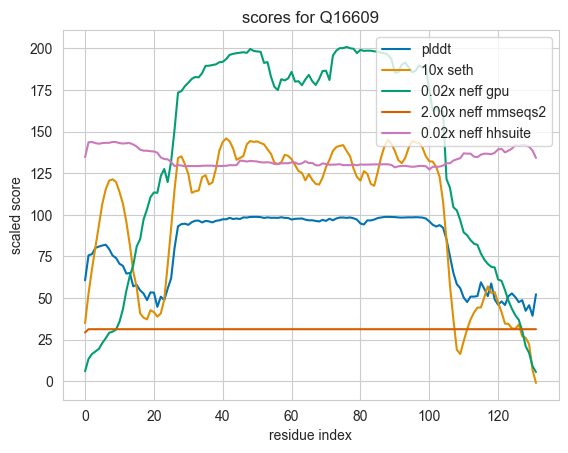

In [15]:
def showscores(protid,sethscale=10.,neff_gpu_scale=.02,neff_mmseqs_scale=2.,neff_hhsuite_scale=0.02):
    plt.plot(plddt[protid],label="plddt",color=colors[0])
    plt.plot(sethscale*seth[protid],label="%.0fx seth" % sethscale,color=colors[1])
    plt.plot(neff_gpu_scale*neff_gpu[protid],label="%.02fx neff gpu" % neff_gpu_scale,color=colors[2])
    plt.plot(neff_mmseqs_scale*neff_mmseqs[protid],label="%.02fx neff mmseqs2" % neff_mmseqs_scale,color=colors[3])
    plt.plot(neff_hhsuite_scale*neff_hhsuite[protid],label="%.02fx neff hhsuite" % neff_hhsuite_scale,color=colors[4])
    plt.xlabel("residue index")
    plt.ylabel("scaled score")
    plt.legend()
    plt.title("scores for %s" % protid)
testid = list(ids)[100]
showscores(testid)

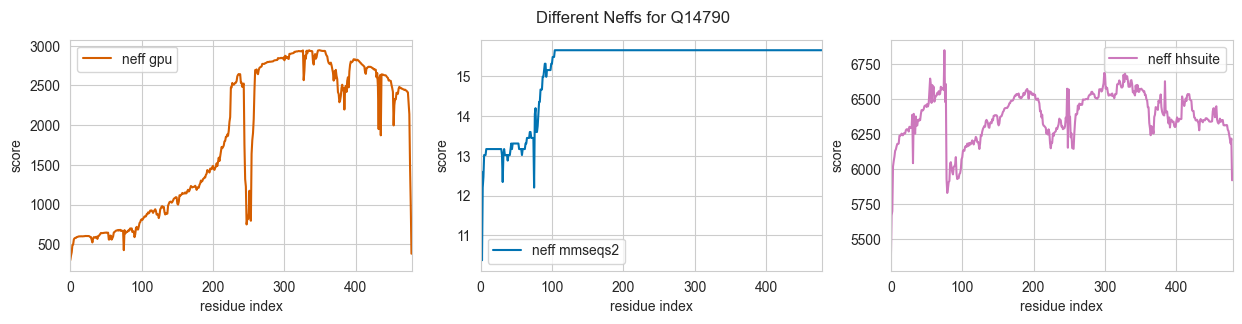

In [16]:
def show_neff_comparison(protid):
    fig, ax = plt.subplots(1,3, figsize=(15,3))
    ax[0].plot(neff_gpu[protid],label="neff gpu",color=colors[3])
    ax[1].plot(neff_mmseqs[protid],label="neff mmseqs2",color=colors[0])
    ax[2].plot(neff_hhsuite[protid],label="neff hhsuite",color=colors[4])
    ax[2].set_xlabel('residue index')
    for a in ax:
        a.set_xlabel("residue index")
        a.set_xlim(0, len(neff_gpu[protid]))
        a.set_ylabel("score")
        a.legend()
    plt.suptitle("Different Neffs for %s" % protid)
# idx = np.random.randint(len(ids))
# print(idx)
# testid = list(ids)[idx]
# show_neff_comparison(testid)
show_neff_comparison(list(ids)[11381])


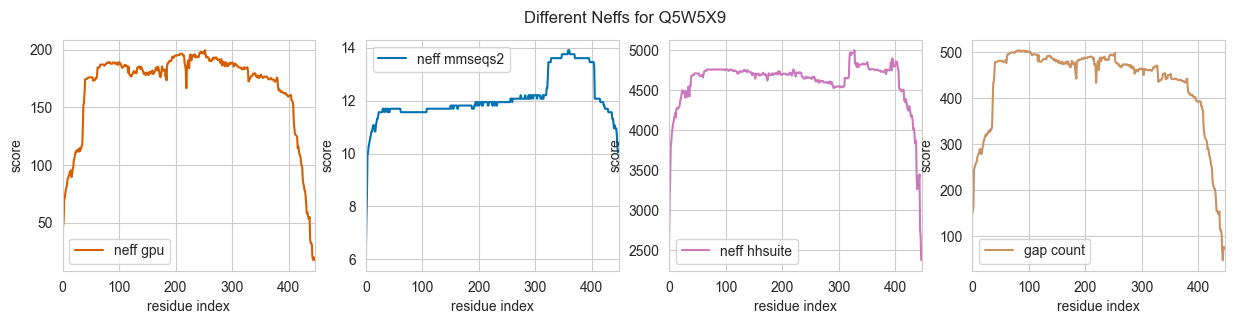

In [17]:
def show_neff_comparison(protid):
    fig, ax = plt.subplots(1,4, figsize=(15,3))
    ax[0].plot(neff_gpu[protid],label="neff gpu",color=colors[3])
    ax[1].plot(neff_mmseqs[protid],label="neff mmseqs2",color=colors[0])
    ax[2].plot(neff_hhsuite[protid],label="neff hhsuite",color=colors[4])
    ax[3].plot(neff_naive[protid],label="gap count",color=colors[5])
    ax[2].set_xlabel('residue index')
    for a in ax:
        a.set_xlabel("residue index")
        a.set_xlim(0, len(neff_gpu[protid]))
        a.set_ylabel("score")
        a.legend()
    plt.suptitle("Different Neffs for %s" % protid)
show_neff_comparison('Q5W5X9')


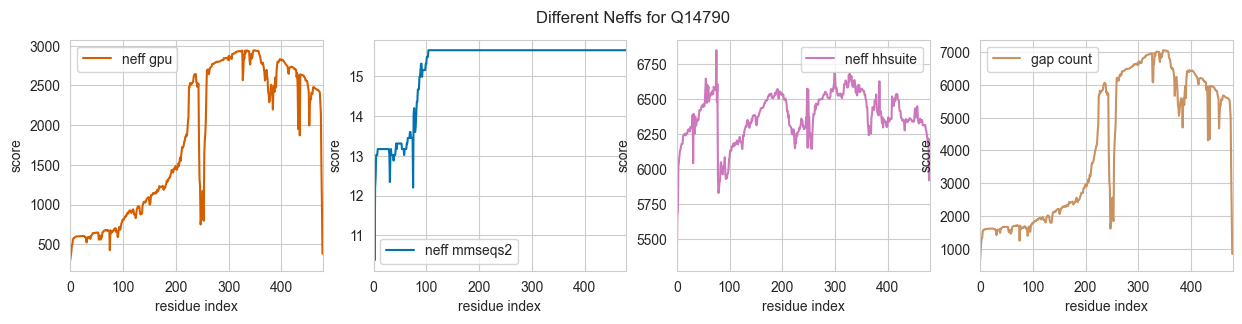

In [18]:
# Hardcore cherrypicked examples
# show_neff_comparison(list(ids)[7143])
# show_neff_comparison(list(ids)[9175])
show_neff_comparison(list(ids)[11381])
# show_neff_comparison(list(ids)[8430])

In [19]:
corrs = {}
scores = {"plddt":plddt,"seth":seth,"neff gpu":neff_gpu,"neff mmseqs2":neff_mmseqs,"neff hhsuite":neff_hhsuite, "gap count":neff_naive}
score2id = {s:i for i,s in enumerate(scores.keys())}
id2score = {i:s for s,i in score2id.items()}
product_momentum_excluded = []
for protid in tqdm(ids,desc="calculating pairwise correlations"):
    st = torch.stack(tuple(score[protid] for score in scores.values()))
    # see if covariance matrix contains zero entries on the diagonal since
    # these would lead to nan entries in the correlation matrix.
    # here, these matrices are set to zeros because there is no variance.
    if len(torch.diag(torch.cov(st)).nonzero()) == len(scores):
        corrs[protid] = torch.corrcoef(st)
    else:
        product_momentum_excluded += [protid]
print("excluded",len(product_momentum_excluded),"proteins due to no variance:")
print(product_momentum_excluded)

calculating pairwise correlations: 100%|██████████| 18270/18270 [00:01<00:00, 13608.20it/s]

excluded 49 proteins due to no variance:
['Q9BZS9', 'A0A075B700', 'A0A0J9YWP8', 'Q15661', 'P20231', 'Q96QG7', 'A0A0C5B5G6', 'Q96IR3', 'Q75NE6', 'Q9BVJ7', 'A0A0A0MT94', 'P11802', 'A0A075B6S0', 'Q9UJ94', 'O43704', 'P51668', 'Q9HBX3', 'Q9GZZ1', 'P61077', 'Q8TCZ7', 'J3KSC0', 'Q0VDD5', 'Q6IMI4', 'P62837', 'Q9P1D8', 'Q96MF0', 'Q49A17', 'O43653', 'Q15493', 'A0A0J9YXG5', 'P0DP58', 'Q8WZA8', 'Q9Y3F1', 'Q9BTD1', 'P20160', 'Q9BQT8', 'A0A0A0MTA7', 'A0A0J9YWX3', 'A0A0B4J200', 'O00338', 'Q0P140', 'Q8IVK1', 'P0C841', 'O75897', 'Q9Y2X8', 'Q8TAB7', 'Q9Y5K2', 'Q0VG73', 'Q9H0P7']


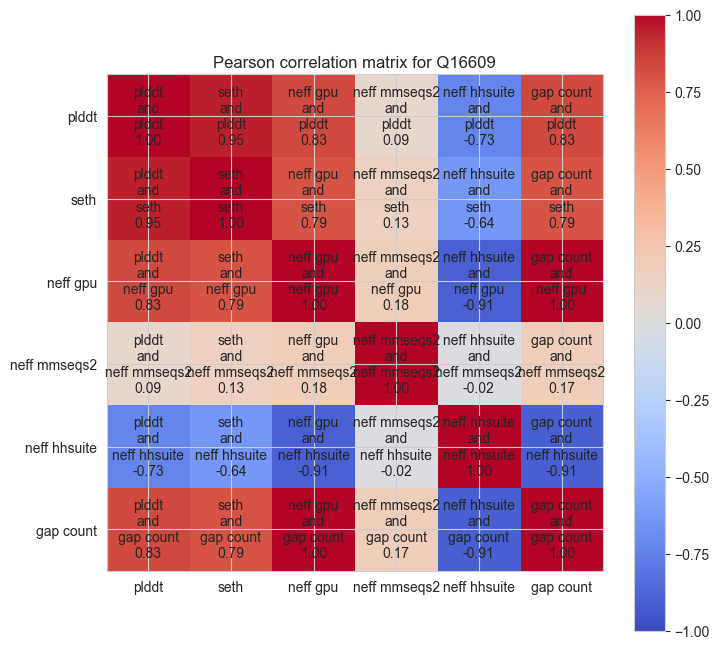

In [20]:
def showcorr(corrmat,name,prefix="",lims=(-1,1),cmap='coolwarm'):
    """show correlation between scores"""
    plt.figure(figsize=(8,8))
    plt.imshow(corrmat, cmap=cmap)
    plt.colorbar()
    plt.title("%sPearson correlation matrix for %s" % (prefix,name))
    plt.xticks(range(len(scores.keys())),scores.keys())
    plt.yticks(range(len(scores.keys())),scores.keys())
    if lims is not None:
        plt.clim(*lims)
    for x,l1 in enumerate(scores.keys()):
        for y,l2 in enumerate(scores.keys()):
            val = corrmat[x][y].item()
            plt.text(x,y,"%s\nand\n%s\n%.02f" % (l1,l2,val),ha="center",va="center")
showcorr(corrs[testid], name=testid)

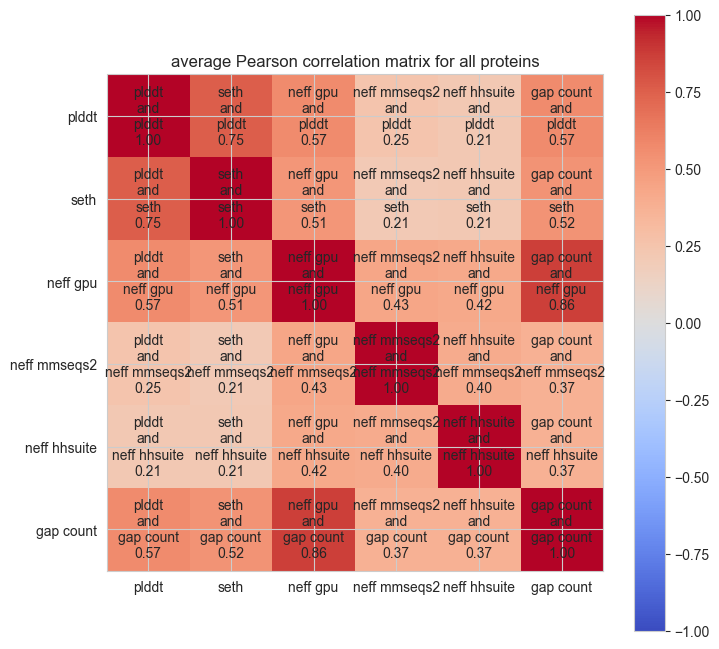

In [21]:
corrstack = torch.stack(tuple(corrs.values()))
corrstd, corravg = torch.std_mean(corrstack,dim=0)
corrmed, _ = torch.median(corrstack, dim=0)
showcorr(corravg, name="all proteins", prefix="average ")

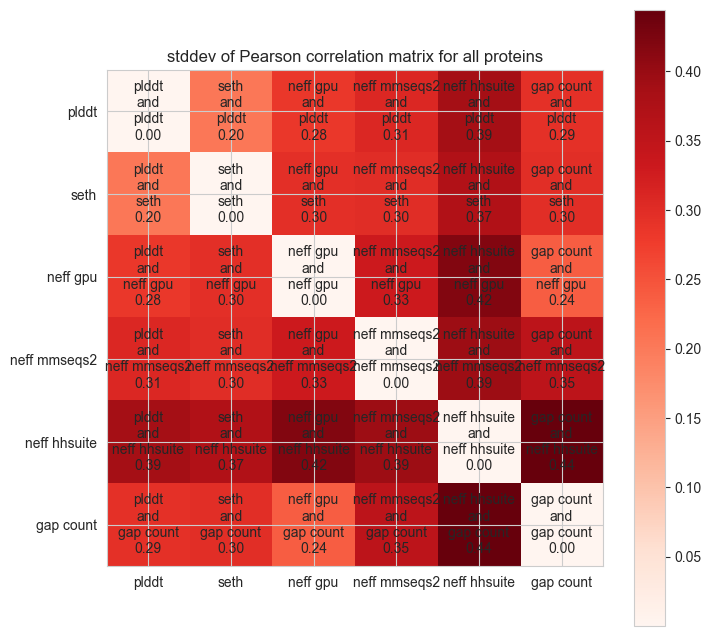

In [22]:
# TODO: why is the diagonal filled with .05???
showcorr(corrstd, name="all proteins", prefix="stddev of ", lims=None, cmap='Reds')

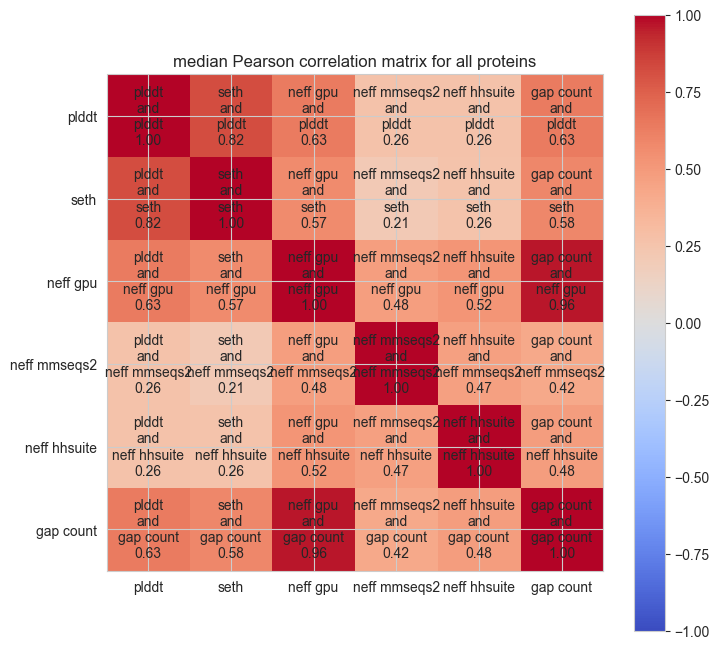

In [23]:
showcorr(corrmed, name="all proteins", prefix="median ")

### Find outliers

In [24]:
neffid,plddtid = score2id["neff gpu"],score2id["plddt"]

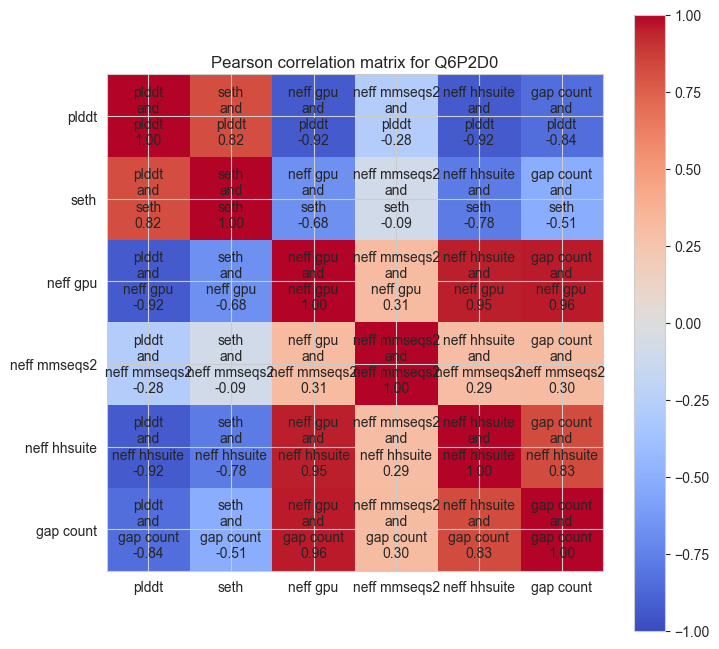

In [25]:
minid,minval = None,float("inf")
for protid in corrs:
    val = corrs[protid][neffid,plddtid].item()
    if minval > val:
        minval = val
        minid  = protid
showcorr(corrs[minid],minid)

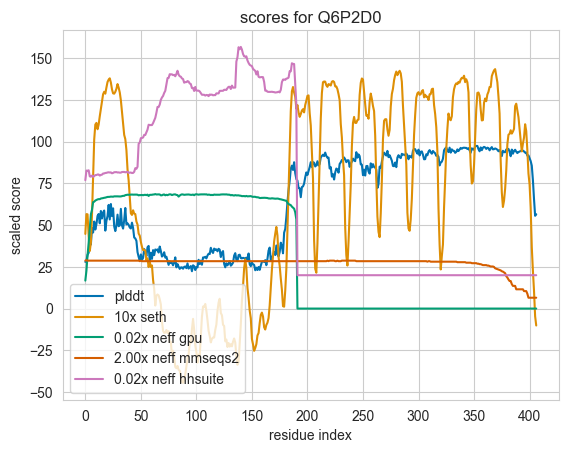

In [26]:
showscores(minid)

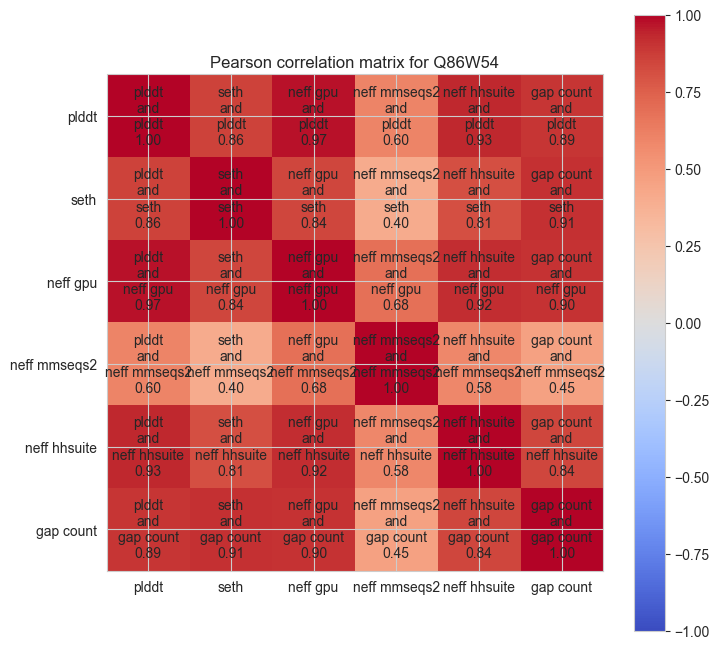

In [27]:
maxid,maxval = None,float("-inf")
for protid in corrs:
    val = corrs[protid][neffid,plddtid].item()
    if maxval < val:
        maxval = val
        maxid  = protid
showcorr(corrs[maxid],maxid)

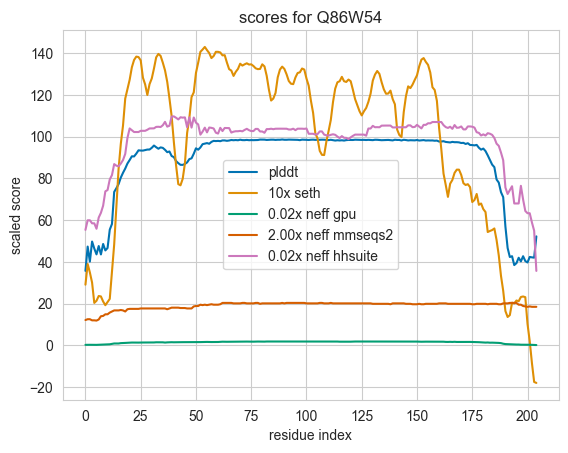

In [28]:
showscores(maxid)

### Bin scores

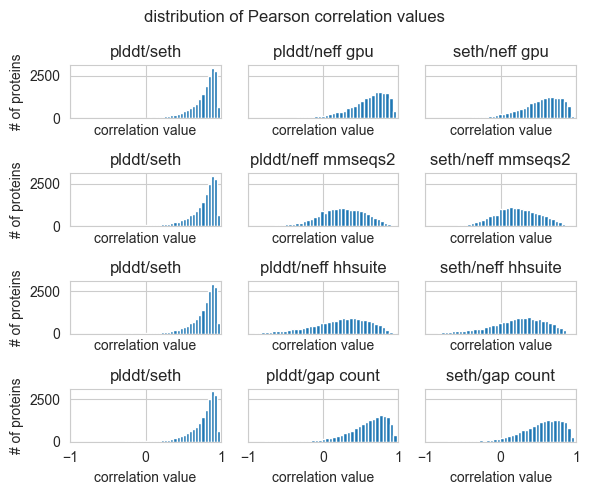

In [29]:
pairs = [
    [("plddt","seth"),("plddt","neff gpu"),("seth","neff gpu")],
    [("plddt","seth"),("plddt","neff mmseqs2"),("seth","neff mmseqs2")],
    [("plddt","seth"),("plddt","neff hhsuite"),("seth","neff hhsuite")],
    [("plddt","seth"),("plddt","gap count"),("seth","gap count")],
]
idpairs = [[(score2id[s1],score2id[s1]) for s1,s2 in p] for p in pairs]
fig,axss = plt.subplots(ncols=len(pairs[0]),nrows=4,figsize=(6,5),sharey=True,sharex=True)
for rowidx,r in enumerate(["neff gpu","neff mmseqs2","neff hhsuite", "gap count"]):
    axs = axss[rowidx]
    for colidx,(ax,p) in enumerate(zip(axs,pairs[rowidx])):
        if colidx == 0:
            ax.set_ylabel("# of proteins")
        
        s1,s2 = p
        id1,id2 = score2id[s1],score2id[s2]

        ax.hist(corrstack[:,id1,id2].sort()[0],bins=40)
        ax.set_title("%s/%s" % p)
        ax.set_xlabel("correlation value")
        ax.set_xlim(-1,1)
fig.suptitle("distribution of Pearson correlation values")
fig.tight_layout()

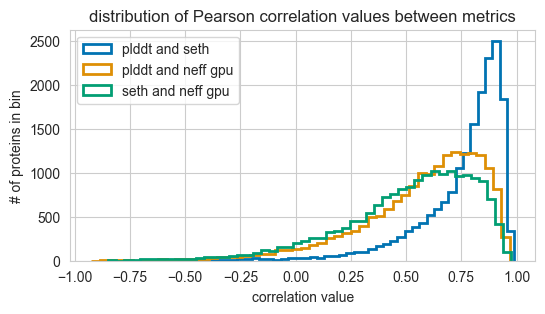

In [30]:
pairs = [("plddt","seth"),("plddt","neff gpu"),("seth","neff gpu")]
plt.figure(figsize=(6,3))
for i,(ax,p) in enumerate(zip(axs,pairs)):
    s1,s2 = p
    id1,id2 = score2id[s1],score2id[s2]
    plt.hist(corrstack[:,id1,id2].sort()[0],bins=50,label="%s and %s" % p,histtype="step",lw=2,color=colors[i])
#plt.axvline(0,label="no correlation",c="k",ls=":")
plt.xlabel("correlation value")
plt.ylabel("# of proteins in bin")
plt.title("distribution of Pearson correlation values between metrics")
plt.legend(loc="upper left");

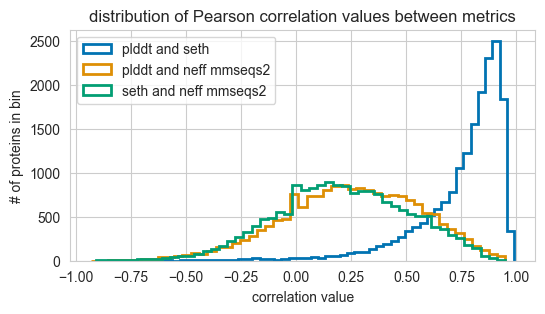

In [31]:
pairs = [("plddt","seth"),("plddt","neff mmseqs2"),("seth","neff mmseqs2")]
plt.figure(figsize=(6,3))
for i,(ax,p) in enumerate(zip(axs,pairs)):
    s1,s2 = p
    id1,id2 = score2id[s1],score2id[s2]
    plt.hist(corrstack[:,id1,id2].sort()[0],bins=50,label="%s and %s" % p,histtype="step",lw=2,color=colors[i])
#plt.axvline(0,label="no correlation",c="k",ls=":")
plt.xlabel("correlation value")
plt.ylabel("# of proteins in bin")
plt.title("distribution of Pearson correlation values between metrics")
plt.legend(loc="upper left");

### More thorough analysis

In [32]:
from scipy import stats
import warnings
from collections import defaultdict
PTHRESH = .05 # Pearson p-value threshold (everything above is discarded)

In [33]:
pearson_corrs, pearson_pvalues = {}, {}
excluded = []
high_pvalues,constant_input = 0,0
per_score_low_pvalues = defaultdict(lambda: 0)
per_score_constant_input = defaultdict(lambda: 0)
prot2highpcount = defaultdict(lambda: 0)
prot2constcount = defaultdict(lambda: 0)
for protid in tqdm(ids,desc="calc'ing Pearson corr"):
    prot_pvalues = torch.zeros((len(scores),)*2)
    prot_corrs = torch.zeros((len(scores),)*2)
    error = False
    for idx1, (score_name1, score1) in enumerate(scores.items()):
        for idx2, (score_name2, score2) in enumerate(scores.items()):
            with warnings.catch_warnings():
                warnings.filterwarnings("error")
                try:
                    res = stats.pearsonr(score1[protid], score2[protid])
                except stats.ConstantInputWarning as e:
                    error = True
                    constant_input += 1
                    prot2constcount[protid] += 1
                    per_score_constant_input[(score_name1,score_name2)] += 1
                else:
                    prot_pvalues[idx1,idx2] = res.pvalue
                    prot_corrs[idx1,idx2] = res.statistic
                    if res.pvalue > PTHRESH:
                        high_pvalues += 1
                        prot2highpcount[protid] += 1
                        per_score_low_pvalues[(score_name1,score_name2)] += 1
                        error = True
    if not error:
        pearson_corrs[protid] = prot_corrs
        pearson_pvalues[protid] = prot_pvalues
    else:
        excluded += [protid]

calc'ing Pearson corr: 100%|██████████| 18270/18270 [00:25<00:00, 725.89it/s]


In [34]:
print("excluded", len(excluded), "proteins due to no variance/constant input or too high pvalue")
print("retained",len(pearson_corrs),"proteins\n")

excluded 10310 proteins due to no variance/constant input or too high pvalue
retained 7960 proteins



In [35]:
n_constant_input = len([protid for protid,count in prot2constcount.items() if count > 0])
print("disregarded",n_constant_input,"proteins due to constant input, this corresponds to {}% of the total".format(round(n_constant_input/total_num_proteins*100,2)),"and {}% of the proteins that passed the test for length match".format(round(n_constant_input/(len(ids))*100,2)))

disregarded 283 proteins due to constant input, this corresponds to 1.37% of the total and 1.55% of the proteins that passed the test for length match


In [36]:
n_highpvalue = len([protid for protid,count in prot2highpcount.items() if count > 0 and protid not in prot2constcount])
print("disregarded",n_highpvalue,"proteins due to too high pvalue, this corresponds to {}% of the total".format(round(n_highpvalue/total_num_proteins*100,2)), "and to {}% of the proteins that passed the test for constant input".format(round(n_highpvalue/(len(ids)-n_constant_input)*100,2)))

disregarded 10027 proteins due to too high pvalue, this corresponds to 48.67% of the total and to 55.75% of the proteins that passed the test for constant input


In [37]:
print(f"In more detail:")
print(f"{constant_input=} of {len(ids)*len(scores)**2} combinations")
print(f"{high_pvalues=} of {len(ids)*len(scores)**2} combinations")
dict_string_const = '\n'.join([str(e) for e in list(per_score_constant_input.items())])
print(f"constant input by score combination:\n {dict_string_const}")
dict_string_low_p = '\n'.join([str(e) for e in list(per_score_low_pvalues.items())])
print(f"\nlow pvalue by score combination:\n {dict_string_low_p}")

In more detail:
constant_input=3488 of 657720 combinations
high_pvalues=48216 of 657720 combinations
constant input by score combination:
 (('plddt', 'neff mmseqs2'), 283)
(('seth', 'neff mmseqs2'), 283)
(('neff gpu', 'neff mmseqs2'), 283)
(('neff mmseqs2', 'plddt'), 283)
(('neff mmseqs2', 'seth'), 283)
(('neff mmseqs2', 'neff gpu'), 283)
(('neff mmseqs2', 'neff mmseqs2'), 283)
(('neff mmseqs2', 'neff hhsuite'), 283)
(('neff mmseqs2', 'gap count'), 283)
(('neff hhsuite', 'neff mmseqs2'), 283)
(('gap count', 'neff mmseqs2'), 283)
(('plddt', 'neff gpu'), 17)
(('plddt', 'neff hhsuite'), 19)
(('plddt', 'gap count'), 17)
(('seth', 'neff gpu'), 17)
(('seth', 'neff hhsuite'), 19)
(('seth', 'gap count'), 17)
(('neff gpu', 'plddt'), 17)
(('neff gpu', 'seth'), 17)
(('neff gpu', 'neff gpu'), 17)
(('neff gpu', 'neff hhsuite'), 19)
(('neff gpu', 'gap count'), 17)
(('neff hhsuite', 'plddt'), 19)
(('neff hhsuite', 'seth'), 19)
(('neff hhsuite', 'neff gpu'), 19)
(('neff hhsuite', 'neff hhsuite'), 19)


Plot contains data for 7960 proteins.


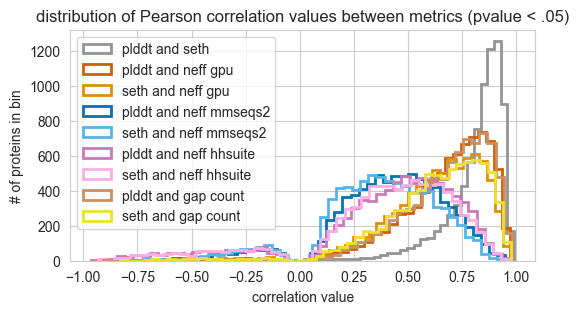

In [38]:
pairs = {
    ("plddt","seth"):colors[-3],
    ("plddt","neff gpu"):colors[3],("seth","neff gpu"):colors[1],
    ("plddt","neff mmseqs2"):colors[0],("seth","neff mmseqs2"):colors[-1],
    ("plddt","neff hhsuite"):colors[4],("seth","neff hhsuite"):colors[6],
    ("plddt","gap count"):colors[5],("seth","gap count"):colors[8],
}
plt.figure(figsize=(6,3))
pearson_corrstack = torch.stack(tuple(pearson_corrs.values()))
print(f"Plot contains data for {pearson_corrstack.shape[0]} proteins.")
for i,(p,c) in enumerate(pairs.items()):
    s1,s2 = p
    id1,id2 = score2id[s1],score2id[s2]
    # c=colors[i]
    plt.hist(pearson_corrstack[:,id1,id2].sort()[0],bins=50,label="%s and %s" % p,histtype="step",lw=2,color=c)
#plt.axvline(0,label="no correlation",c="k",ls=":")
plt.xlabel("correlation value")
plt.ylabel("# of proteins in bin")
plt.title("distribution of Pearson correlation values between metrics (pvalue < .05)")
plt.legend(loc="upper left");

Plot contains data for 7960 proteins.


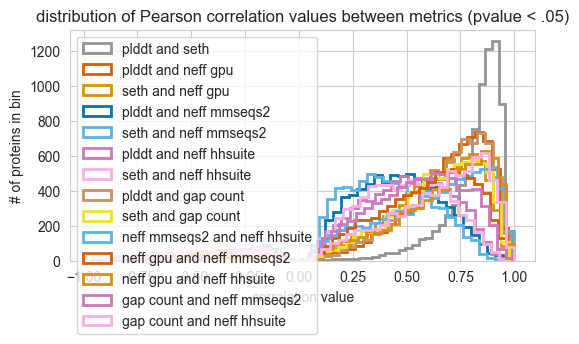

In [39]:
pairs = {
    ("plddt","seth"):colors[-3],
    ("plddt","neff gpu"):colors[3],("seth","neff gpu"):colors[1],
    ("plddt","neff mmseqs2"):colors[0],("seth","neff mmseqs2"):colors[-1],
    ("plddt","neff hhsuite"):colors[4],("seth","neff hhsuite"):colors[6],
    ("plddt","gap count"):colors[5],("seth","gap count"):colors[8],
    ("neff mmseqs2","neff hhsuite"):colors[-1],
    ("neff gpu","neff mmseqs2"):colors[3],("neff gpu","neff hhsuite"):colors[1],
    ("gap count","neff mmseqs2"):colors[4],
    ("gap count","neff hhsuite"):colors[6],
}
plt.figure(figsize=(6,3))
pearson_corrstack = torch.stack(tuple(pearson_corrs.values()))
print(f"Plot contains data for {pearson_corrstack.shape[0]} proteins.")
for i,(p,c) in enumerate(pairs.items()):
    s1,s2 = p
    id1,id2 = score2id[s1],score2id[s2]
    # c=colors[i]
    plt.hist(pearson_corrstack[:,id1,id2].sort()[0],bins=50,label="%s and %s" % p,histtype="step",lw=2,color=c)
#plt.axvline(0,label="no correlation",c="k",ls=":")
plt.xlabel("correlation value")
plt.ylabel("# of proteins in bin")
plt.title("distribution of Pearson correlation values between metrics (pvalue < .05)")
plt.legend(loc="upper left");

Plot contains data for 7960 proteins.


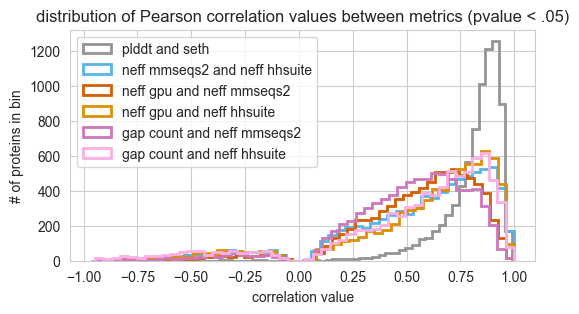

In [40]:
pairs = {
    ("plddt","seth"):colors[-3],
    # ("neff gpu","gap count"):colors[0],
    ("neff mmseqs2","neff hhsuite"):colors[-1],
    ("neff gpu","neff mmseqs2"):colors[3],("neff gpu","neff hhsuite"):colors[1],
    ("gap count","neff mmseqs2"):colors[4],
    ("gap count","neff hhsuite"):colors[6],
}
plt.figure(figsize=(6,3))
pearson_corrstack = torch.stack(tuple(pearson_corrs.values()))
print(f"Plot contains data for {pearson_corrstack.shape[0]} proteins.")
for i,(p,c) in enumerate(pairs.items()):
    s1,s2 = p
    id1,id2 = score2id[s1],score2id[s2]
    # c=colors[i]
    plt.hist(pearson_corrstack[:,id1,id2].sort()[0],bins=50,label="%s and %s" % p,histtype="step",lw=2,color=c)
#plt.axvline(0,label="no correlation",c="k",ls=":")
plt.xlabel("correlation value")
plt.ylabel("# of proteins in bin")
plt.title("distribution of Pearson correlation values between metrics (pvalue < .05)")
plt.legend(loc="upper left");

Plot contains data for 7960 proteins.


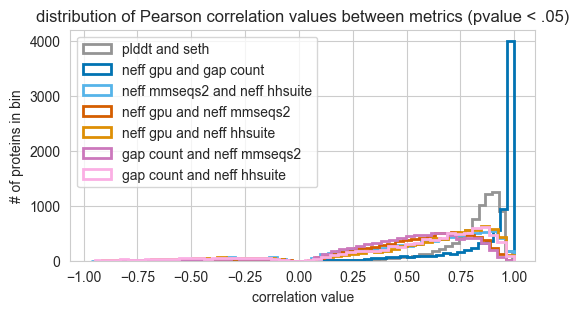

In [41]:
pairs = {
    ("plddt","seth"):colors[-3],
    ("neff gpu","gap count"):colors[0],
    ("neff mmseqs2","neff hhsuite"):colors[-1],
    ("neff gpu","neff mmseqs2"):colors[3],("neff gpu","neff hhsuite"):colors[1],
    ("gap count","neff mmseqs2"):colors[4],
    ("gap count","neff hhsuite"):colors[6],
}
plt.figure(figsize=(6,3))
pearson_corrstack = torch.stack(tuple(pearson_corrs.values()))
print(f"Plot contains data for {pearson_corrstack.shape[0]} proteins.")
for i,(p,c) in enumerate(pairs.items()):
    s1,s2 = p
    id1,id2 = score2id[s1],score2id[s2]
    # c=colors[i]
    plt.hist(pearson_corrstack[:,id1,id2].sort()[0],bins=50,label="%s and %s" % p,histtype="step",lw=2,color=c)
#plt.axvline(0,label="no correlation",c="k",ls=":")
plt.xlabel("correlation value")
plt.ylabel("# of proteins in bin")
plt.title("distribution of Pearson correlation values between metrics (pvalue < .05)")
plt.legend(loc="upper left");

Plot contains data for 7960 proteins.


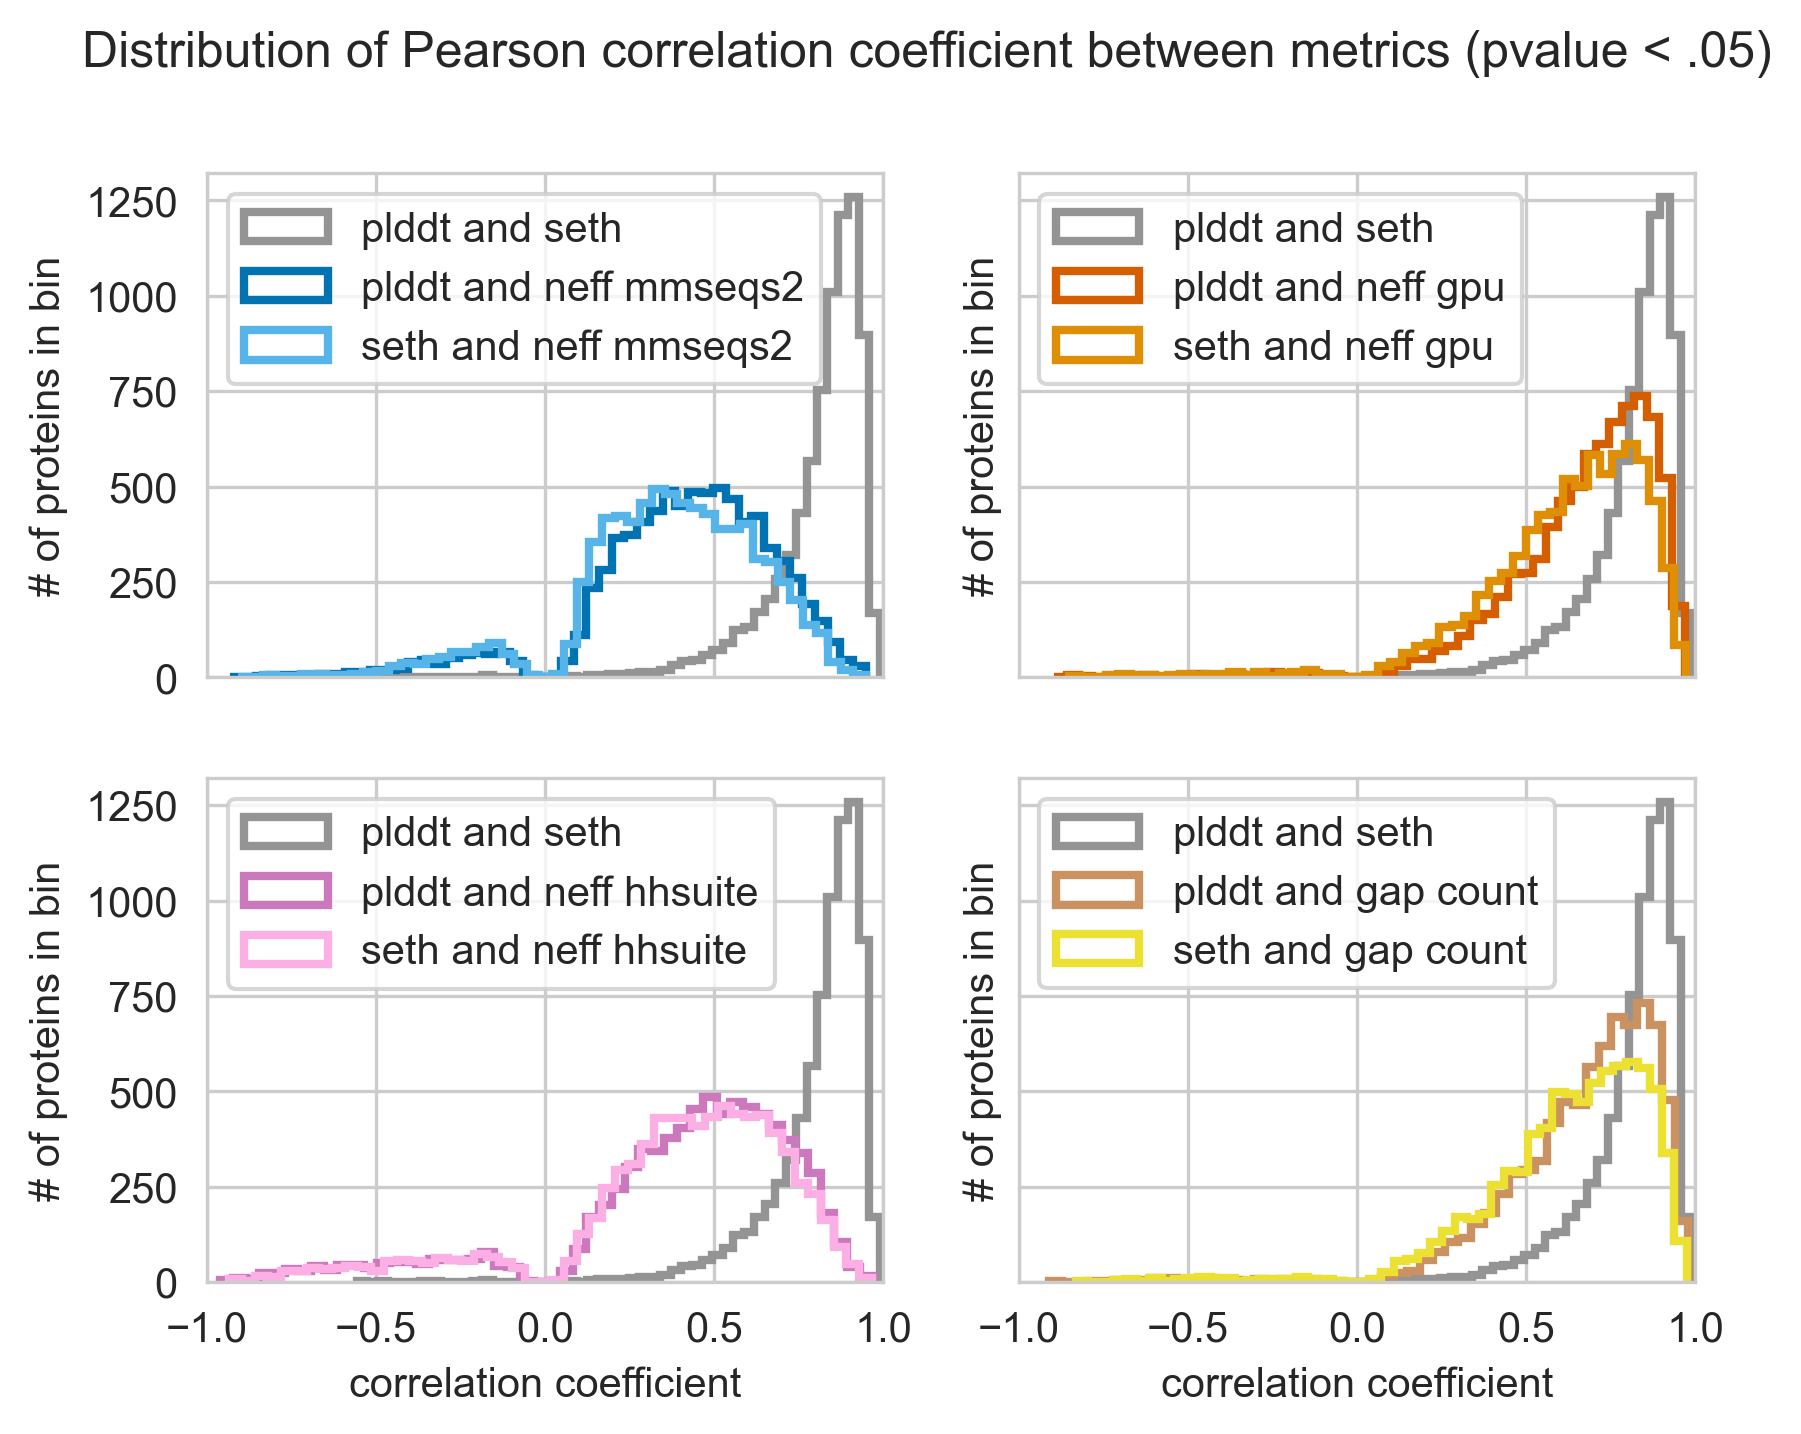

In [42]:
pairs = {
    (0,1): {("plddt","seth"):colors[-3], ("plddt","neff gpu"):colors[3], ("seth","neff gpu"):colors[1],},
    (0,0): {("plddt","seth"):colors[-3], ("plddt","neff mmseqs2"):colors[0], ("seth","neff mmseqs2"):colors[-1],},
    (1,0): {("plddt","seth"):colors[-3], ("plddt","neff hhsuite"):colors[4], ("seth","neff hhsuite"):colors[6],},
    (1,1): {("plddt","seth"):colors[-3], ("plddt","gap count"):colors[5], ("seth","gap count"):colors[8],}
}
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
fig.suptitle("Distribution of Pearson correlation coefficient between metrics (pvalue < .05)")
pearson_corrstack = torch.stack(tuple(pearson_corrs.values()))
print(f"Plot contains data for {pearson_corrstack.shape[0]} proteins.")
for a in ax.flatten():
    a.set_xlim(-1,1)
fig.set_dpi(300)
for x,y in [(0,0),(0,1),(1,0),(1,1)]:
    for i,(p,c) in enumerate(pairs[(x,y)].items()):
        s1,s2 = p
        id1,id2 = score2id[s1],score2id[s2]

        ax[x,y].hist(pearson_corrstack[:,id1,id2].sort()[0],bins=50,label="%s and %s" % p,histtype="step",lw=2,color=c)
    if x == 1:
        ax[x,y].set_xlabel("correlation coefficient")
    ax[x,y].set_ylabel("# of proteins in bin")
    ax[x,y].legend(loc="upper left")

## Alternative filtering

Not removing the protein if only some correlations have too high pvalue

In [43]:
pearson_corrs, pearson_pvalues = {}, {}
excluded = []
high_pvalues,constant_input = 0,0
per_score_low_pvalues = defaultdict(lambda: 0)
per_score_constant_input = defaultdict(lambda: 0)
prot2highpcount = defaultdict(lambda: 0)
prot2constcount = defaultdict(lambda: 0)
for protid in tqdm(ids,desc="calc'ing Pearson corr"):
    prot_pvalues = torch.zeros((len(scores),)*2)
    prot_corrs = torch.zeros((len(scores),)*2)
    error = False
    for idx1, (score_name1, score1) in enumerate(scores.items()):
        for idx2, (score_name2, score2) in enumerate(scores.items()):
            with warnings.catch_warnings():
                warnings.filterwarnings("error")
                try:
                    res = stats.pearsonr(score1[protid], score2[protid])
                except stats.ConstantInputWarning as e:
                    error = True
                    constant_input += 1
                    prot2constcount[protid] += 1
                    per_score_constant_input[(score_name1,score_name2)] += 1
                    prot_pvalues[idx1,idx2] = float('nan')
                    prot_corrs[idx1,idx2] = float('nan')
                else:
                    prot_pvalues[idx1,idx2] = res.pvalue
                    prot_corrs[idx1,idx2] = res.statistic
                    if res.pvalue > PTHRESH:
                        high_pvalues += 1
                        prot2highpcount[protid] += 1
                        per_score_low_pvalues[(score_name1,score_name2)] += 1
                        error = True
                        # prot_pvalues[idx1,idx2] = float('nan')
                        # prot_corrs[idx1,idx2] = float('nan')
    pearson_corrs[protid] = prot_corrs
    pearson_pvalues[protid] = prot_pvalues

calc'ing Pearson corr: 100%|██████████| 18270/18270 [00:27<00:00, 659.50it/s]


Plot contains data for 18270 proteins.


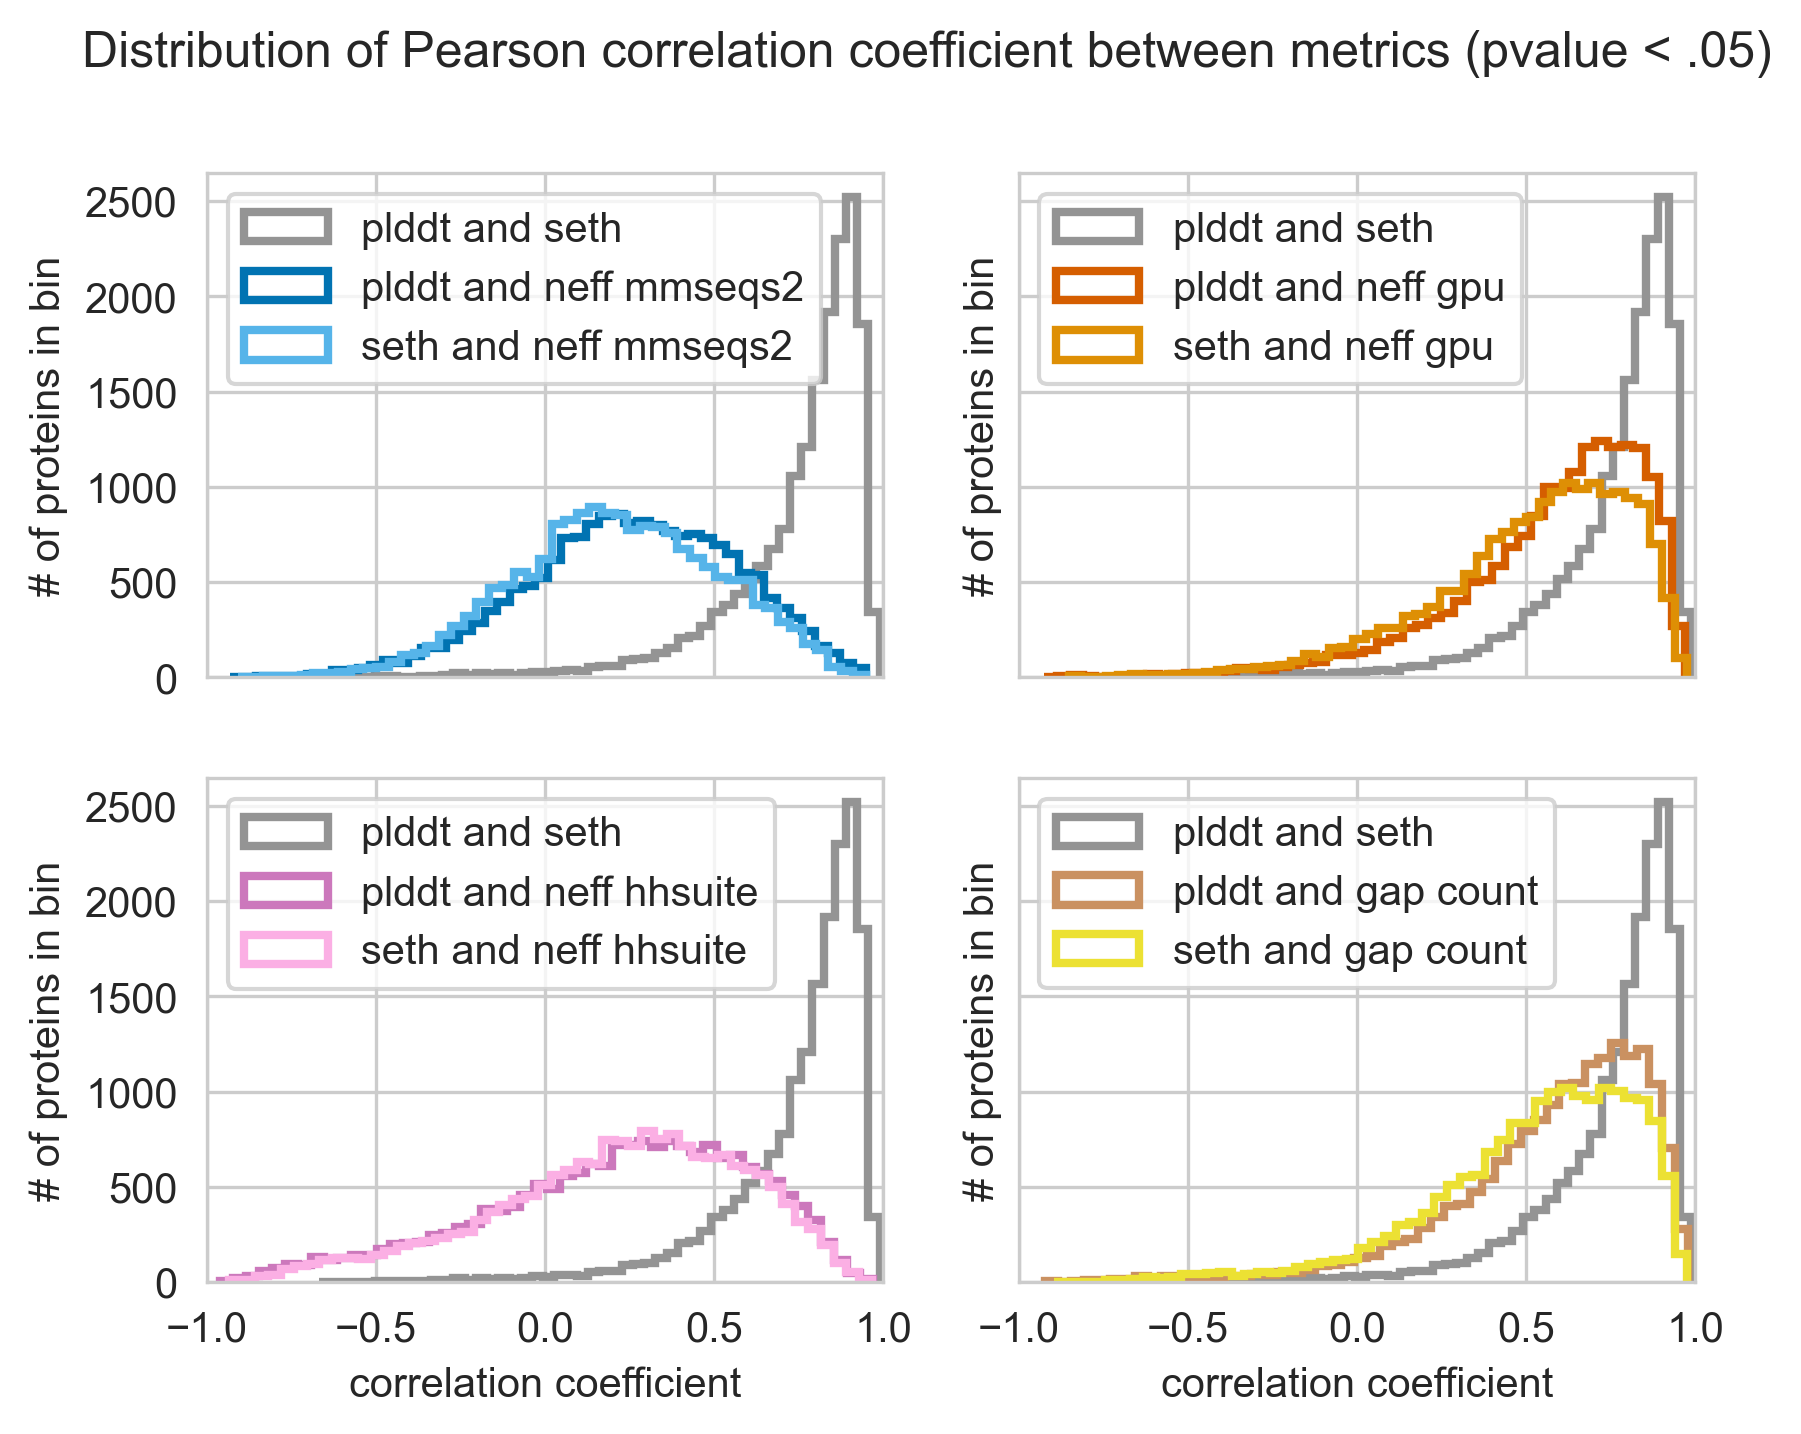

In [44]:
pairs = {
    (0,1): {("plddt","seth"):colors[-3], ("plddt","neff gpu"):colors[3], ("seth","neff gpu"):colors[1],},
    (0,0): {("plddt","seth"):colors[-3], ("plddt","neff mmseqs2"):colors[0], ("seth","neff mmseqs2"):colors[-1],},
    (1,0): {("plddt","seth"):colors[-3], ("plddt","neff hhsuite"):colors[4], ("seth","neff hhsuite"):colors[6],},
    (1,1): {("plddt","seth"):colors[-3], ("plddt","gap count"):colors[5], ("seth","gap count"):colors[8],}
}
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
fig.suptitle("Distribution of Pearson correlation coefficient between metrics (pvalue < .05)")
pearson_corrstack = torch.stack(tuple(pearson_corrs.values()))
print(f"Plot contains data for {pearson_corrstack.shape[0]} proteins.")
for a in ax.flatten():
    a.set_xlim(-1,1)
fig.set_dpi(300)
for x,y in [(0,0),(0,1),(1,0),(1,1)]:
    for i,(p,c) in enumerate(pairs[(x,y)].items()):
        s1,s2 = p
        id1,id2 = score2id[s1],score2id[s2]

        ax[x,y].hist(pearson_corrstack[:,id1,id2].sort()[0],bins=50,label="%s and %s" % p,histtype="step",lw=2,color=c)
    if x == 1:
        ax[x,y].set_xlabel("correlation coefficient")
    ax[x,y].set_ylabel("# of proteins in bin")
    ax[x,y].legend(loc="upper left")

In [56]:
pearson_corrs, pearson_pvalues = {}, {}
excluded = []
high_pvalues,constant_input = 0,0
per_score_low_pvalues = defaultdict(lambda: [])
per_score_constant_input = defaultdict(lambda: 0)
prot2highpcount = defaultdict(lambda: 0)
prot2constcount = defaultdict(lambda: 0)
for protid in tqdm(ids,desc="calc'ing Pearson corr"):
    prot_pvalues = torch.zeros((len(scores),)*2)
    prot_corrs = torch.zeros((len(scores),)*2)
    error = False
    for idx1, (score_name1, score1) in enumerate(scores.items()):
        for idx2, (score_name2, score2) in enumerate(scores.items()):
            with warnings.catch_warnings():
                warnings.filterwarnings("error")
                try:
                    res = stats.pearsonr(score1[protid], score2[protid])
                except stats.ConstantInputWarning as e:
                    error = True
                    constant_input += 1
                    prot2constcount[protid] += 1
                    per_score_constant_input[(score_name1,score_name2)] += 1
                else:
                    prot_pvalues[idx1,idx2] = res.pvalue
                    prot_corrs[idx1,idx2] = res.statistic
                    if res.pvalue > PTHRESH:
                        high_pvalues += 1
                        prot2highpcount[protid] += 1
                        per_score_low_pvalues[(score_name1,score_name2)] += [protid]
                        # error = True
                        prot_pvalues[idx1,idx2] = float('nan')
                        prot_corrs[idx1,idx2] = float('nan')
    if not error:
        pearson_corrs[protid] = prot_corrs
        pearson_pvalues[protid] = prot_pvalues
    else:
        excluded += [protid]

calc'ing Pearson corr: 100%|██████████| 18270/18270 [00:25<00:00, 719.31it/s]


Plot contains data for 17987 proteins.


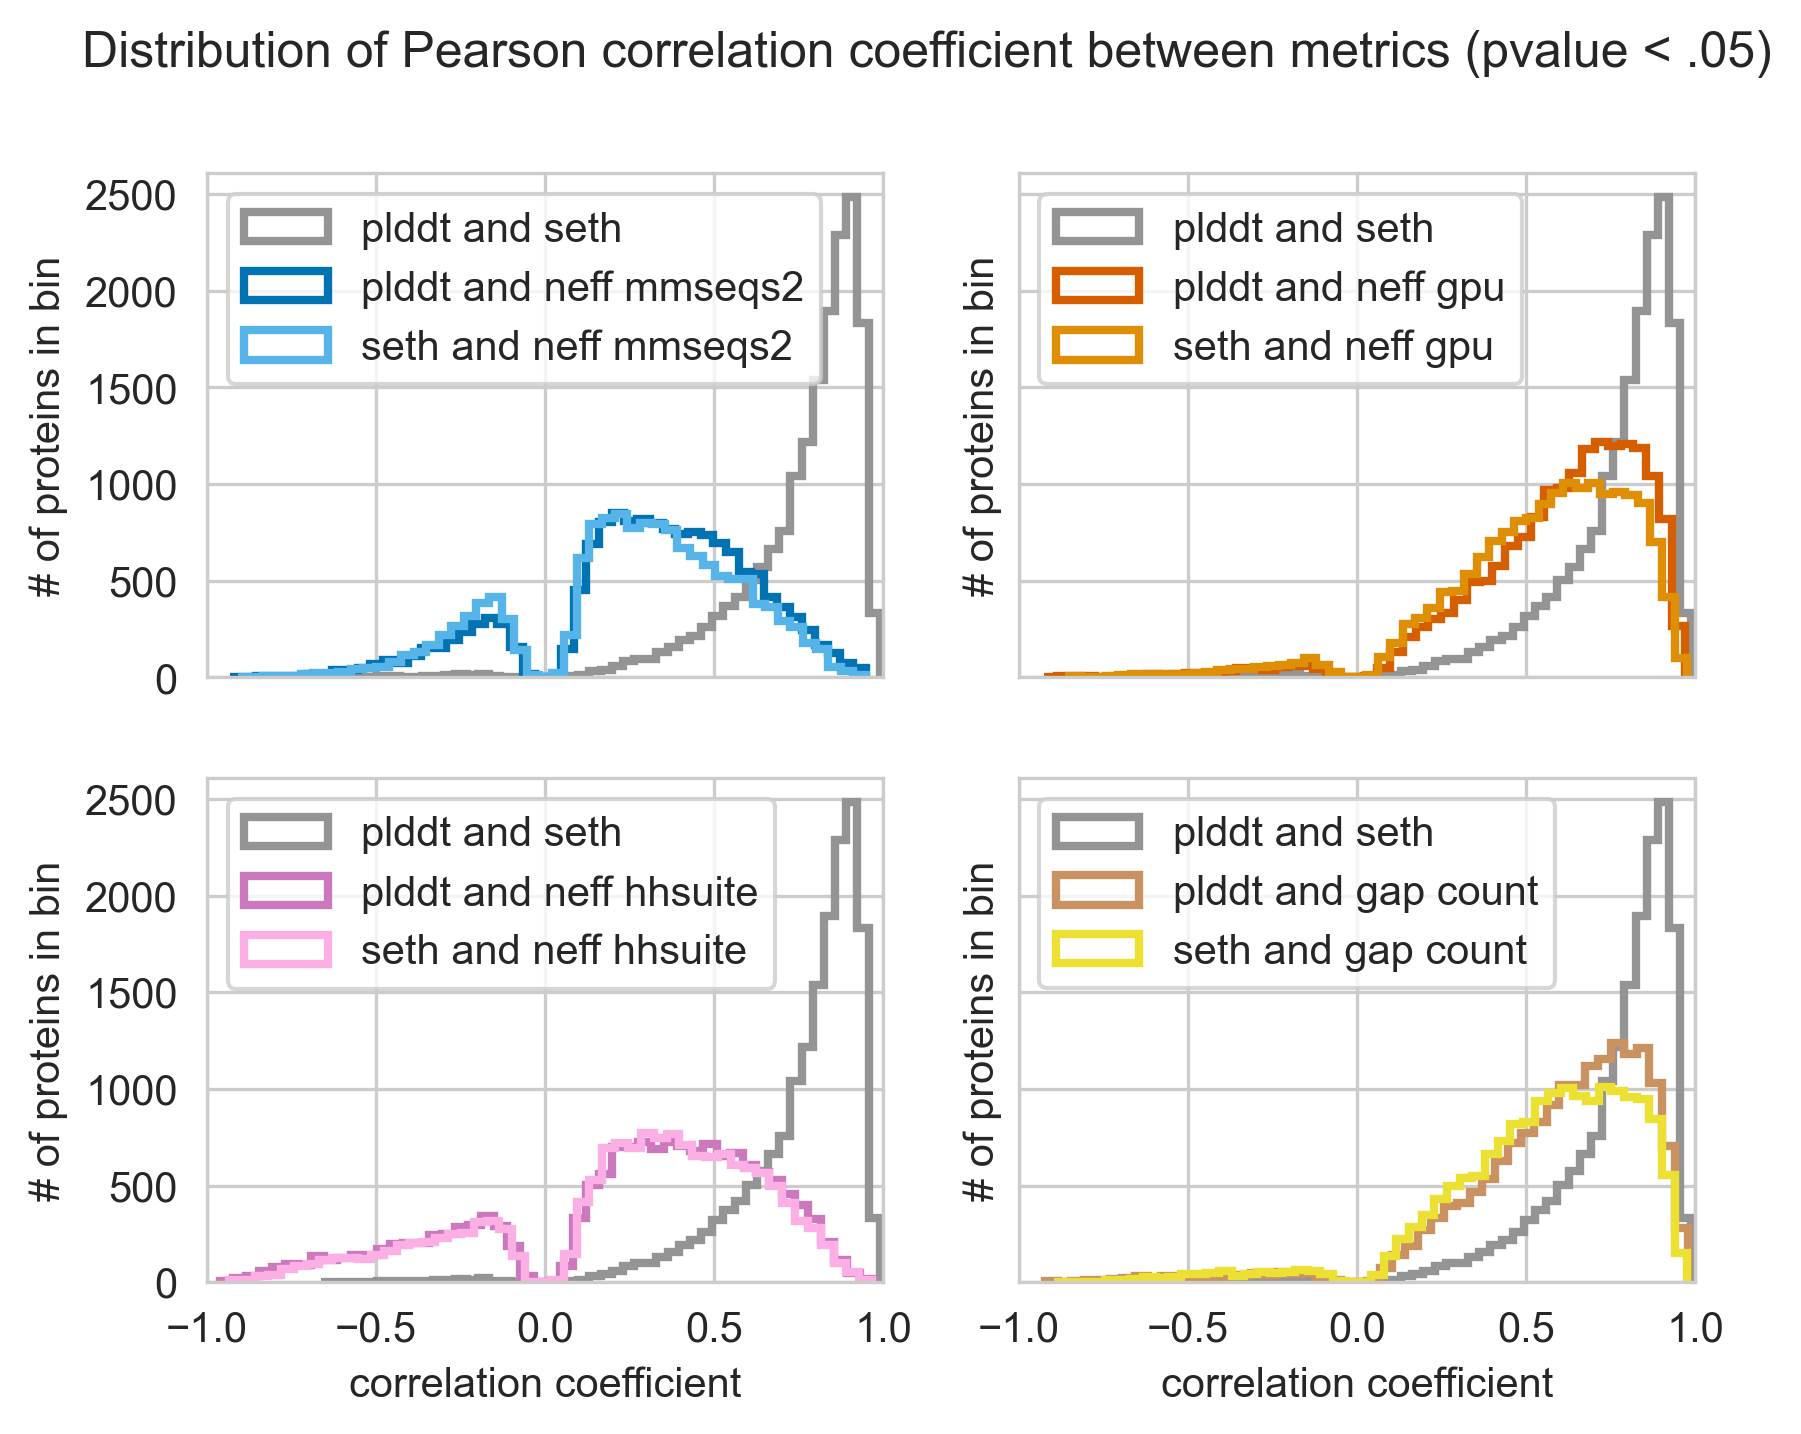

In [57]:
pairs = {
    (0,1): {("plddt","seth"):colors[-3], ("plddt","neff gpu"):colors[3], ("seth","neff gpu"):colors[1],},
    (0,0): {("plddt","seth"):colors[-3], ("plddt","neff mmseqs2"):colors[0], ("seth","neff mmseqs2"):colors[-1],},
    (1,0): {("plddt","seth"):colors[-3], ("plddt","neff hhsuite"):colors[4], ("seth","neff hhsuite"):colors[6],},
    (1,1): {("plddt","seth"):colors[-3], ("plddt","gap count"):colors[5], ("seth","gap count"):colors[8],}
}
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
fig.suptitle("Distribution of Pearson correlation coefficient between metrics (pvalue < .05)")
pearson_corrstack = torch.stack(tuple(pearson_corrs.values()))
print(f"Plot contains data for {pearson_corrstack.shape[0]} proteins.")
for a in ax.flatten():
    a.set_xlim(-1,1)
fig.set_dpi(300)
for x,y in [(0,0),(0,1),(1,0),(1,1)]:
    for i,(p,c) in enumerate(pairs[(x,y)].items()):
        s1,s2 = p
        id1,id2 = score2id[s1],score2id[s2]

        ax[x,y].hist(pearson_corrstack[:,id1,id2].sort()[0],bins=50,label="%s and %s" % p,histtype="step",lw=2,color=c)
    if x == 1:
        ax[x,y].set_xlabel("correlation coefficient")
    ax[x,y].set_ylabel("# of proteins in bin")
    ax[x,y].legend(loc="upper left")

Plot contains data for 17987 proteins.


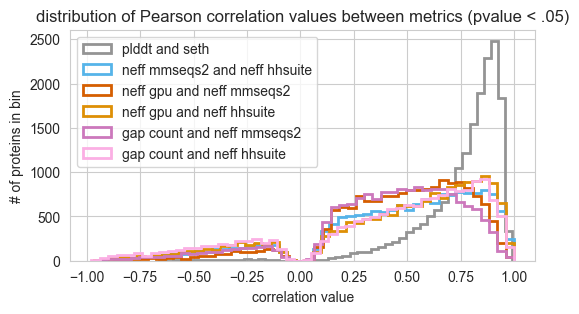

In [58]:
pairs = {
    ("plddt","seth"):colors[-3],
    # ("neff gpu","gap count"):colors[0],
    ("neff mmseqs2","neff hhsuite"):colors[-1],
    ("neff gpu","neff mmseqs2"):colors[3],("neff gpu","neff hhsuite"):colors[1],
    ("gap count","neff mmseqs2"):colors[4],
    ("gap count","neff hhsuite"):colors[6],
}
plt.figure(figsize=(6,3))
pearson_corrstack = torch.stack(tuple(pearson_corrs.values()))
print(f"Plot contains data for {pearson_corrstack.shape[0]} proteins.")
for i,(p,c) in enumerate(pairs.items()):
    s1,s2 = p
    id1,id2 = score2id[s1],score2id[s2]
    # c=colors[i]
    plt.hist(pearson_corrstack[:,id1,id2].sort()[0],bins=50,label="%s and %s" % p,histtype="step",lw=2,color=c)
#plt.axvline(0,label="no correlation",c="k",ls=":")
plt.xlabel("correlation value")
plt.ylabel("# of proteins in bin")
plt.title("distribution of Pearson correlation values between metrics (pvalue < .05)")
plt.legend(loc="upper left");

Plot contains data for 17987 proteins.


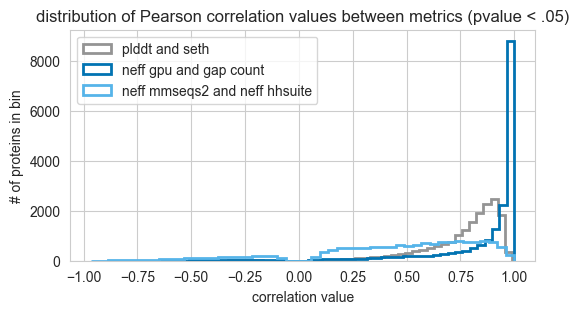

In [59]:
pairs = {
    ("plddt","seth"):colors[-3],
    ("neff gpu","gap count"):colors[0],
    ("neff mmseqs2","neff hhsuite"):colors[-1],
}
plt.figure(figsize=(6,3))
pearson_corrstack = torch.stack(tuple(pearson_corrs.values()))
print(f"Plot contains data for {pearson_corrstack.shape[0]} proteins.")
for i,(p,c) in enumerate(pairs.items()):
    s1,s2 = p
    id1,id2 = score2id[s1],score2id[s2]
    # c=colors[i]
    plt.hist(pearson_corrstack[:,id1,id2].sort()[0],bins=50,label="%s and %s" % p,histtype="step",lw=2,color=c)
#plt.axvline(0,label="no correlation",c="k",ls=":")
plt.xlabel("correlation value")
plt.ylabel("# of proteins in bin")
plt.title("distribution of Pearson correlation values between metrics (pvalue < .05)")
plt.legend(loc="upper left");

Plot contains data for 17987 proteins.


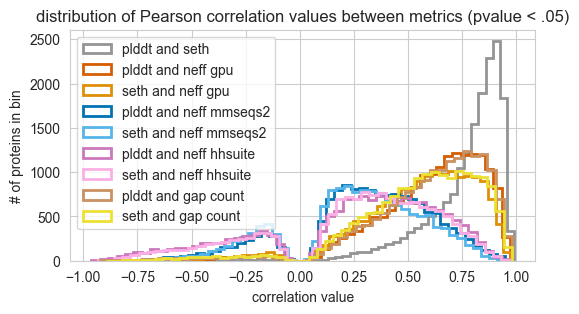

In [60]:
pairs = {
    ("plddt","seth"):colors[-3],
    ("plddt","neff gpu"):colors[3],("seth","neff gpu"):colors[1],
    ("plddt","neff mmseqs2"):colors[0],("seth","neff mmseqs2"):colors[-1],
    ("plddt","neff hhsuite"):colors[4],("seth","neff hhsuite"):colors[6],
    ("plddt","gap count"):colors[5],("seth","gap count"):colors[8],
}
plt.figure(figsize=(6,3))
pearson_corrstack = torch.stack(tuple(pearson_corrs.values()))
print(f"Plot contains data for {pearson_corrstack.shape[0]} proteins.")
for i,(p,c) in enumerate(pairs.items()):
    s1,s2 = p
    id1,id2 = score2id[s1],score2id[s2]
    # c=colors[i]
    plt.hist(pearson_corrstack[:,id1,id2].sort()[0],bins=50,label="%s and %s" % p,histtype="step",lw=2,color=c)
#plt.axvline(0,label="no correlation",c="k",ls=":")
plt.xlabel("correlation value")
plt.ylabel("# of proteins in bin")
plt.title("distribution of Pearson correlation values between metrics (pvalue < .05)")
plt.legend(loc="upper left");

Plot contains data for 17987 proteins.


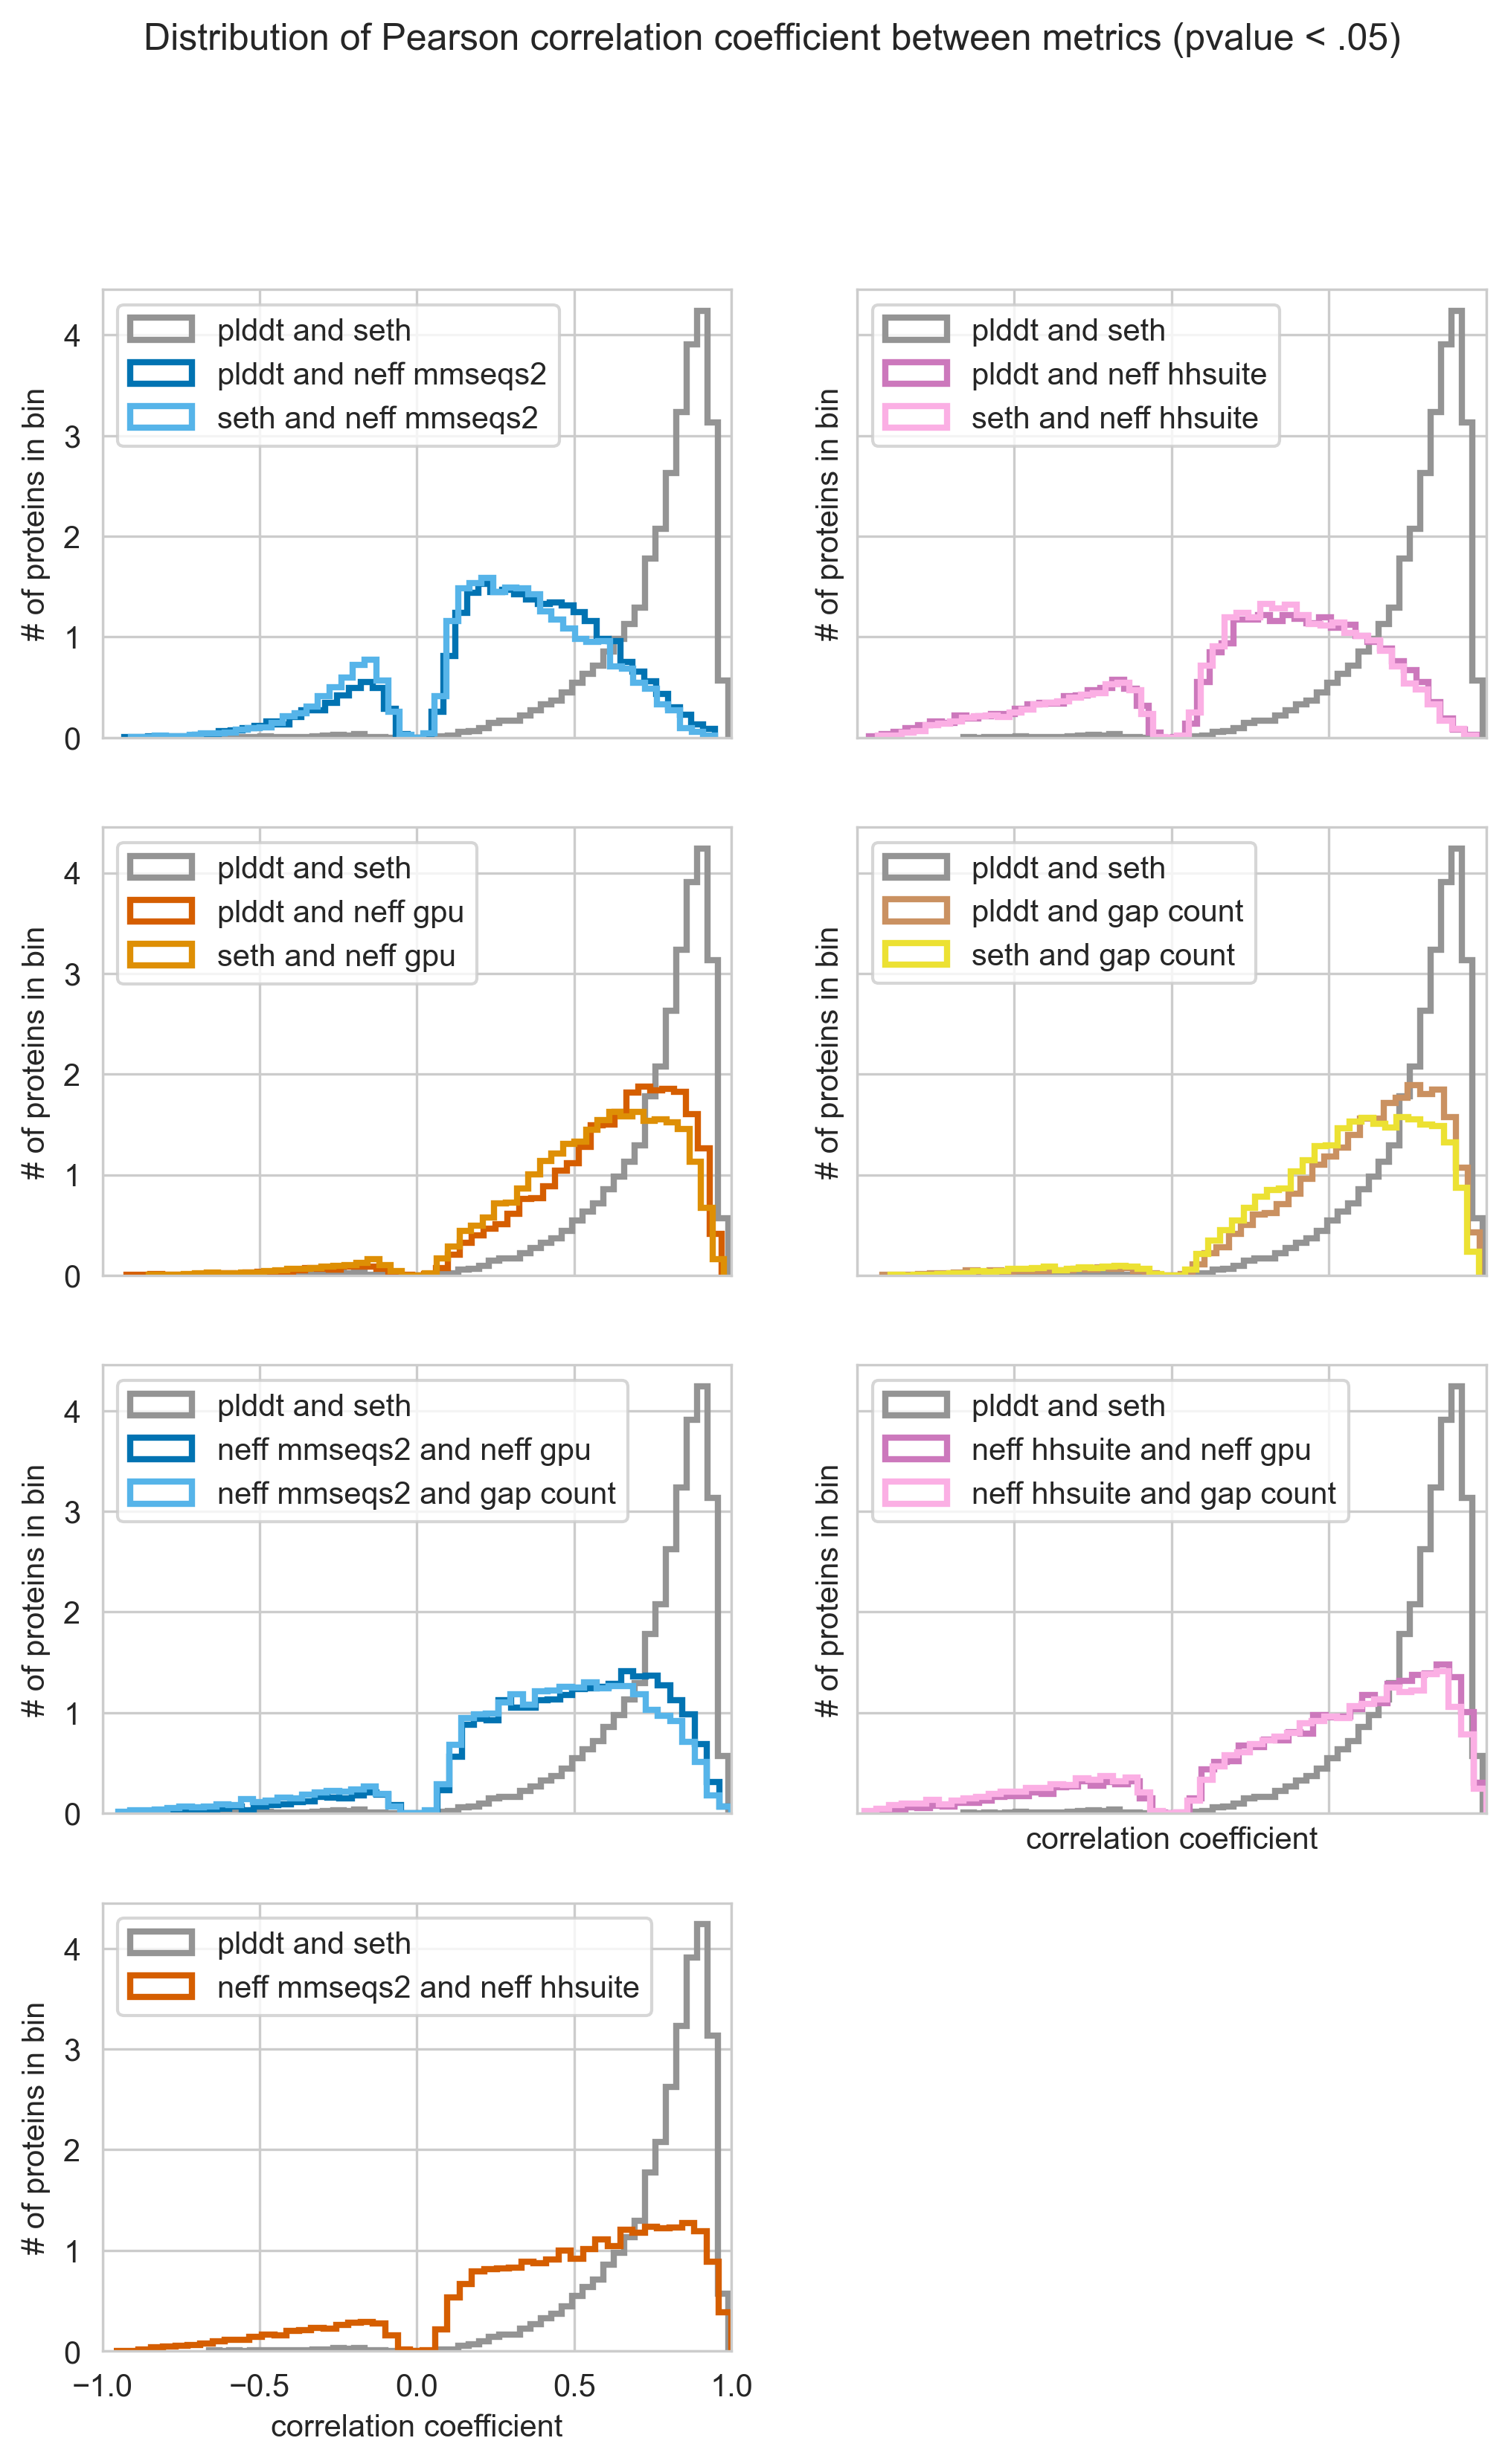

In [66]:
pairs = {
    (1,0): {("plddt","seth"):colors[-3], ("plddt","neff gpu"):colors[3], ("seth","neff gpu"):colors[1],},
    (0,0): {("plddt","seth"):colors[-3], ("plddt","neff mmseqs2"):colors[0], ("seth","neff mmseqs2"):colors[-1],},
    (0,1): {("plddt","seth"):colors[-3], ("plddt","neff hhsuite"):colors[4], ("seth","neff hhsuite"):colors[6],},
    (1,1): {("plddt","seth"):colors[-3], ("plddt","gap count"):colors[5], ("seth","gap count"):colors[8],},
    (2,1): {("plddt","seth"):colors[-3], ("neff hhsuite", "neff gpu"):colors[4], ("neff hhsuite", "gap count"):colors[6],},
    (2,0): {("plddt","seth"):colors[-3], ("neff mmseqs2", "neff gpu"):colors[0], ("neff mmseqs2", "gap count"):colors[-1],},
    (3,0): {("plddt","seth"):colors[-3], ("neff mmseqs2", "neff hhsuite"):colors[3]},
}
fig, ax = plt.subplots(4, 2, sharex=True, sharey=True, figsize=(8, 12))
fig.suptitle("Distribution of Pearson correlation coefficient between metrics (pvalue < .05)")
pearson_corrstack = torch.stack(tuple(pearson_corrs.values()))
print(f"Plot contains data for {pearson_corrstack.shape[0]} proteins.")
for a in ax.flatten():
    a.set_xlim(-1,1)
fig.set_dpi(300)
for x,y in [(0,0),(0,1),(1,0),(1,1), (2,0), (2,1), (3,0)]:
    for i,(p,c) in enumerate(pairs[(x,y)].items()):
        s1,s2 = p
        id1,id2 = score2id[s1],score2id[s2]

        ax[x,y].hist(pearson_corrstack[:,id1,id2].sort()[0],bins=50,label="%s and %s" % p,density=True,histtype="step",lw=2,color=c)
    if (x == 2 and y == 1) or (x == 3 and y == 0):
        ax[x,y].set_xlabel("correlation coefficient")
    ax[x,y].set_ylabel("# of proteins in bin")
    ax[x,y].legend(loc="upper left")
ax[3,1].set_axis_off()
ax[3,1].set_frame_on(False)

In [62]:
# per_score_low_pvalues is a dictionary of lists of the following form:
# {("metric_name1","metric_name2"): [prot_id1, prot_id2, ...], ...}
# build a new dictionary with the counts of proteins in each metric pair
per_score_low_pvalues_counts = {}
for pair, prot_ids in per_score_low_pvalues.items():
    per_score_low_pvalues_counts[pair] = len(prot_ids)

for pair, count in per_score_low_pvalues_counts.items():
    print(f"{pair}: {count}")

('plddt', 'neff hhsuite'): 2614
('neff hhsuite', 'plddt'): 2614
('seth', 'neff gpu'): 1082
('neff gpu', 'seth'): 1082
('neff mmseqs2', 'neff hhsuite'): 2008
('neff hhsuite', 'neff mmseqs2'): 2008
('plddt', 'neff mmseqs2'): 3129
('seth', 'neff mmseqs2'): 3587
('neff mmseqs2', 'plddt'): 3129
('neff mmseqs2', 'seth'): 3587
('seth', 'gap count'): 932
('gap count', 'seth'): 932
('seth', 'neff hhsuite'): 2767
('neff gpu', 'neff hhsuite'): 1494
('neff hhsuite', 'seth'): 2767
('neff hhsuite', 'neff gpu'): 1494
('neff mmseqs2', 'gap count'): 1557
('gap count', 'neff mmseqs2'): 1557
('plddt', 'neff gpu'): 825
('plddt', 'gap count'): 773
('neff gpu', 'plddt'): 825
('gap count', 'plddt'): 773
('neff hhsuite', 'gap count'): 1555
('gap count', 'neff hhsuite'): 1555
('neff gpu', 'neff mmseqs2'): 1377
('neff mmseqs2', 'neff gpu'): 1377
('plddt', 'seth'): 268
('seth', 'plddt'): 268
('neff gpu', 'gap count'): 140
('gap count', 'neff gpu'): 140


In [63]:
spearman_corrs, spearman_pvalues = {}, {}
excluded = []
high_pvalues,constant_input = 0,0
per_score_low_pvalues = defaultdict(lambda: [])
per_score_constant_input = defaultdict(lambda: 0)
prot2highpcount = defaultdict(lambda: 0)
prot2constcount = defaultdict(lambda: 0)
for protid in tqdm(ids,desc="calc'ing Pearson corr"):
    prot_pvalues = torch.zeros((len(scores),)*2)
    prot_corrs = torch.zeros((len(scores),)*2)
    error = False
    for idx1, (score_name1, score1) in enumerate(scores.items()):
        for idx2, (score_name2, score2) in enumerate(scores.items()):
            with warnings.catch_warnings():
                warnings.filterwarnings("error")
                try:
                    res = stats.spearmanr(score1[protid], score2[protid])
                except stats.ConstantInputWarning as e:
                    error = True
                    constant_input += 1
                    prot2constcount[protid] += 1
                    per_score_constant_input[(score_name1,score_name2)] += 1
                else:
                    prot_pvalues[idx1,idx2] = res.pvalue
                    prot_corrs[idx1,idx2] = res.correlation
                    if res.pvalue > PTHRESH:
                        high_pvalues += 1
                        prot2highpcount[protid] += 1
                        per_score_low_pvalues[(score_name1,score_name2)] += [protid]
                        # error = True
                        prot_pvalues[idx1,idx2] = float('nan')
                        prot_corrs[idx1,idx2] = float('nan')
    if not error:
        spearman_corrs[protid] = prot_corrs
        spearman_pvalues[protid] = prot_pvalues
    else:
        excluded += [protid]

calc'ing Pearson corr: 100%|██████████| 18270/18270 [01:46<00:00, 171.69it/s]


Plot contains data for 17987 proteins.


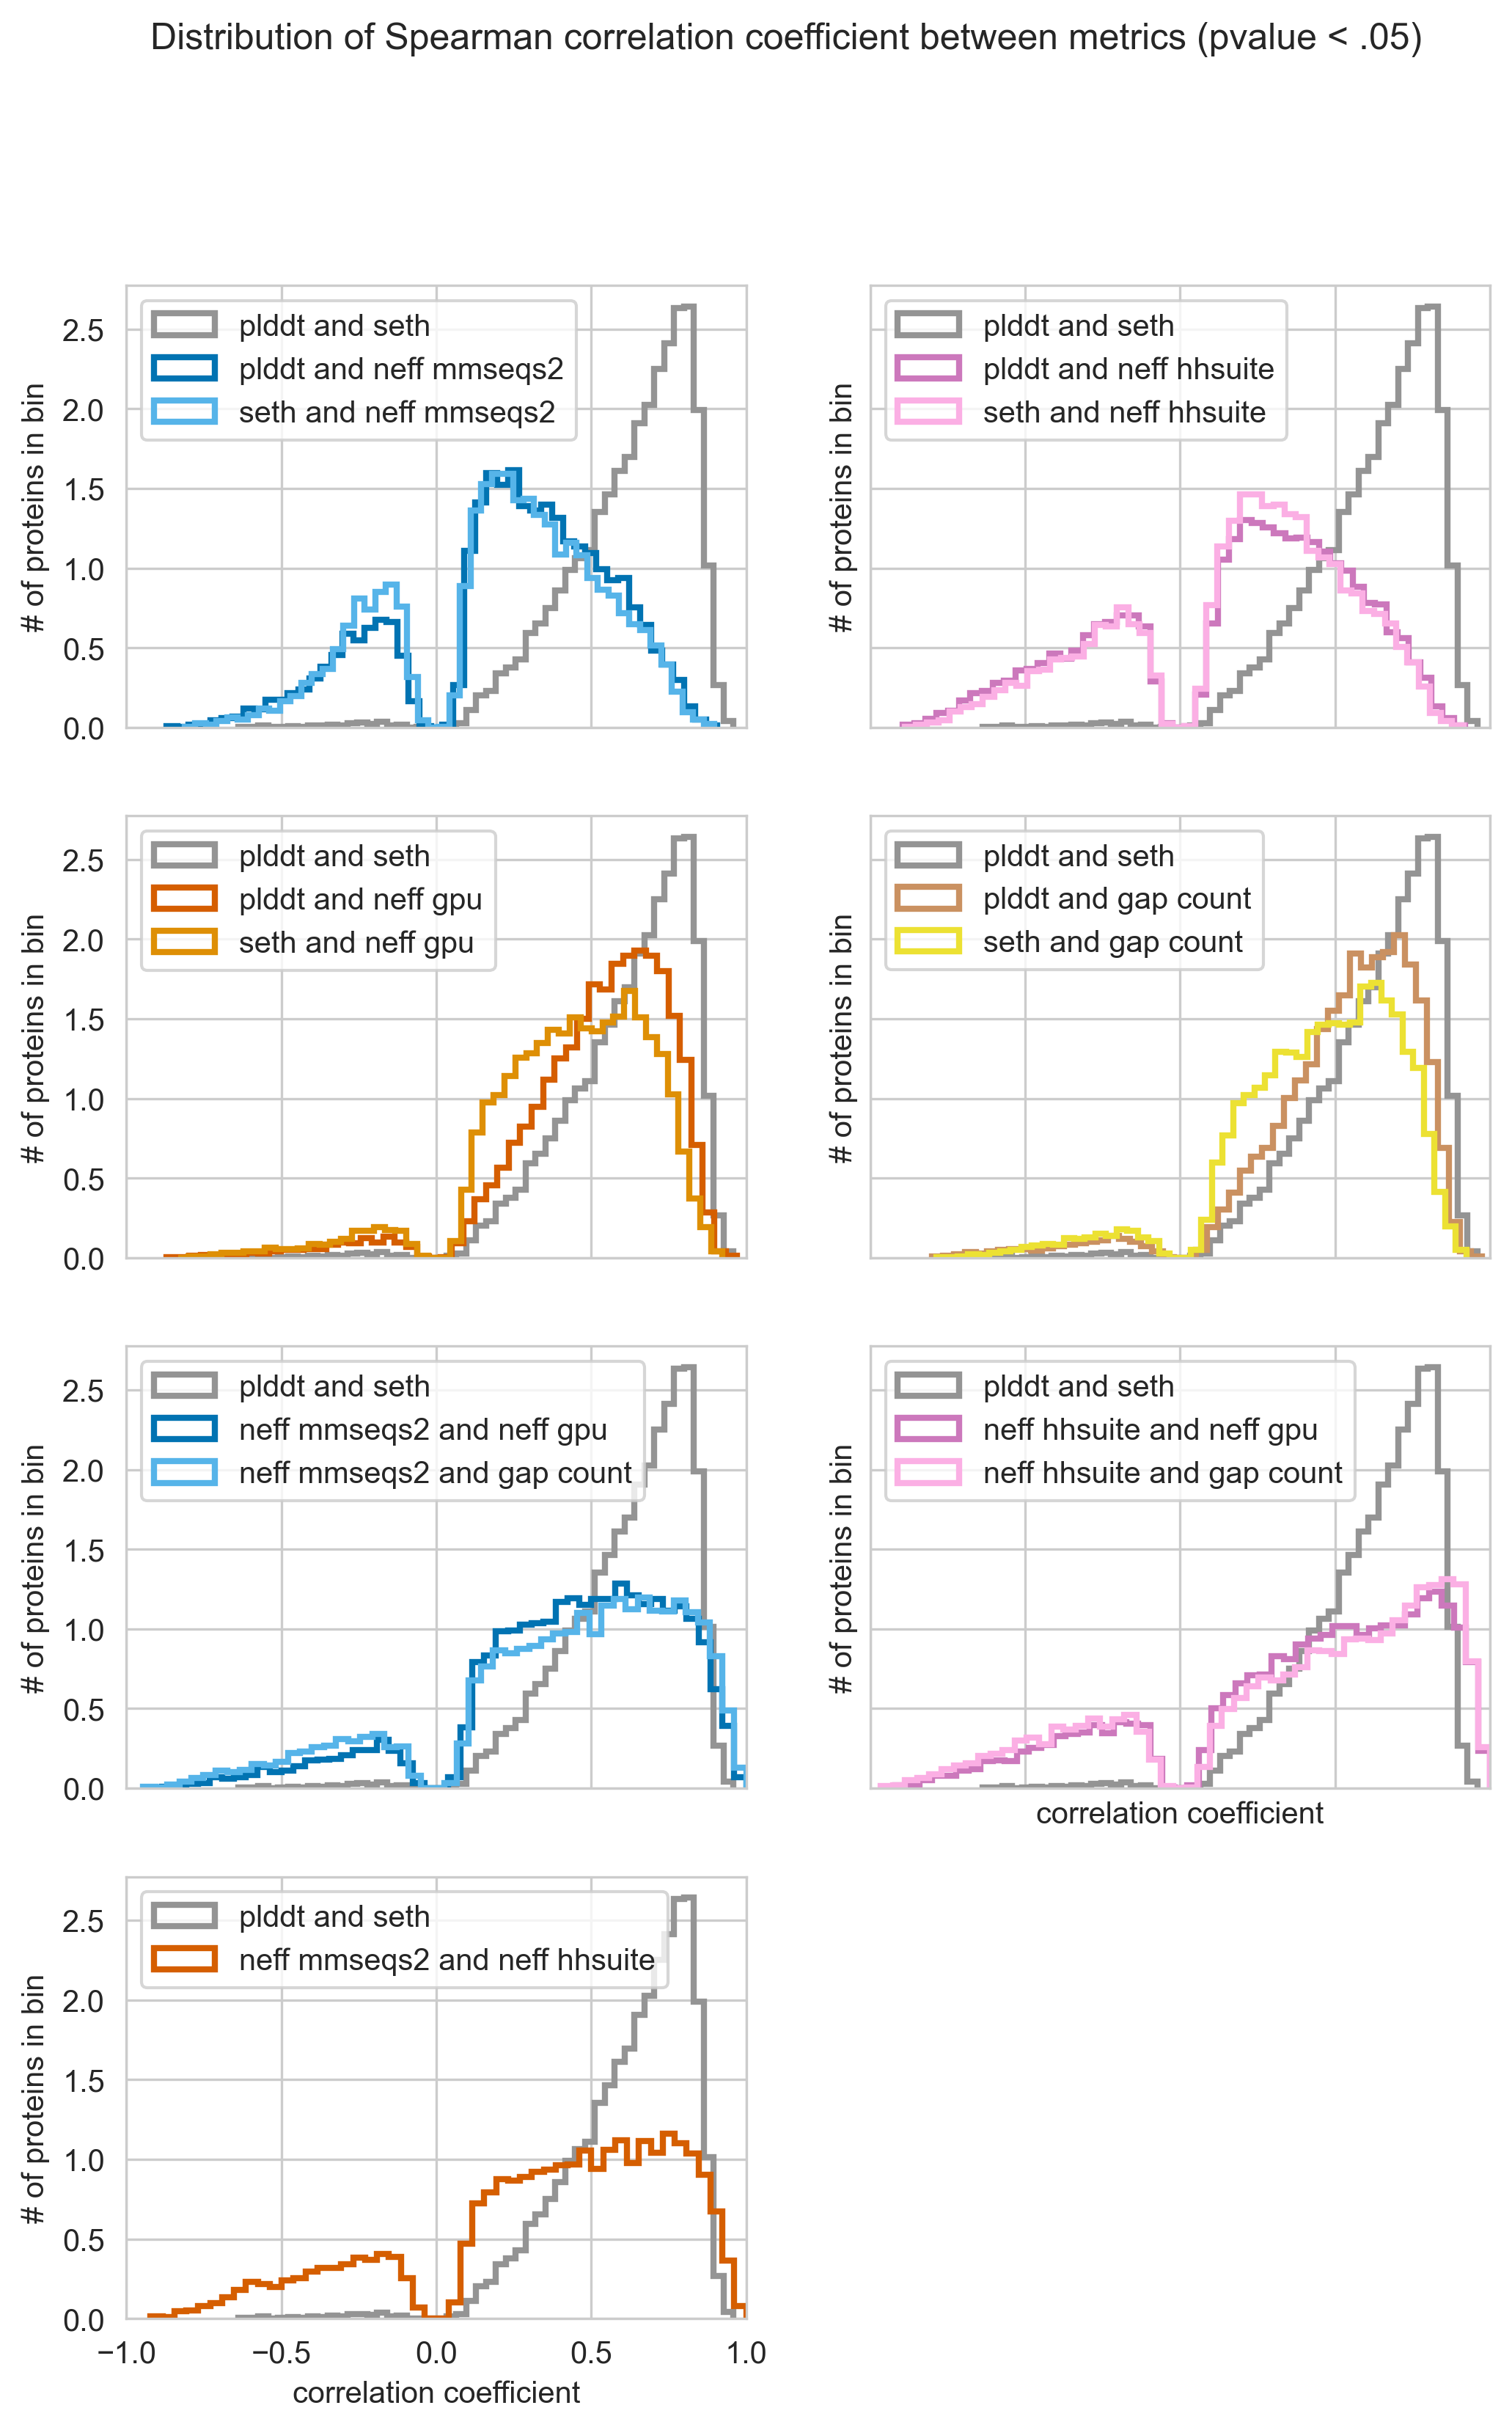

In [65]:
pairs = {
    (1,0): {("plddt","seth"):colors[-3], ("plddt","neff gpu"):colors[3], ("seth","neff gpu"):colors[1],},
    (0,0): {("plddt","seth"):colors[-3], ("plddt","neff mmseqs2"):colors[0], ("seth","neff mmseqs2"):colors[-1],},
    (0,1): {("plddt","seth"):colors[-3], ("plddt","neff hhsuite"):colors[4], ("seth","neff hhsuite"):colors[6],},
    (1,1): {("plddt","seth"):colors[-3], ("plddt","gap count"):colors[5], ("seth","gap count"):colors[8],},
    (2,1): {("plddt","seth"):colors[-3], ("neff hhsuite", "neff gpu"):colors[4], ("neff hhsuite", "gap count"):colors[6],},
    (2,0): {("plddt","seth"):colors[-3], ("neff mmseqs2", "neff gpu"):colors[0], ("neff mmseqs2", "gap count"):colors[-1],},
    (3,0): {("plddt","seth"):colors[-3], ("neff mmseqs2", "neff hhsuite"):colors[3]},
}
fig, ax = plt.subplots(4, 2, sharex=True, sharey=True, figsize=(8, 12))
fig.suptitle("Distribution of Spearman correlation coefficient between metrics (pvalue < .05)")
spearman_corrstack = torch.stack(tuple(spearman_corrs.values()))
print(f"Plot contains data for {spearman_corrstack.shape[0]} proteins.")
for a in ax.flatten():
    a.set_xlim(-1,1)
fig.set_dpi(300)
for x,y in [(0,0),(0,1),(1,0),(1,1), (2,0), (2,1), (3,0)]:
    for i,(p,c) in enumerate(pairs[(x,y)].items()):
        s1,s2 = p
        id1,id2 = score2id[s1],score2id[s2]

        ax[x,y].hist(spearman_corrstack[:,id1,id2].sort()[0],bins=50,label="%s and %s" % p,density=True,histtype="step",lw=2,color=c)
    if (x == 2 and y == 1) or (x == 3 and y == 0):
        ax[x,y].set_xlabel("correlation coefficient")
    ax[x,y].set_ylabel("# of proteins in bin")
    ax[x,y].legend(loc="upper left")
ax[3,1].set_axis_off()
ax[3,1].set_frame_on(False)